In [229]:
import pandas as pd
import os
import re
from datetime import datetime as dt
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import time
import random
import pickle
from functools import reduce
import matplotlib.patches as patches
from datapackage import Package
from iso3166 import countries
import plotly.io as pio
import math
from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency
from scipy.stats import linregress
import json

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Regional Analysis

## Analysis: How do trending videos compare regarding number countries trended in and number of days videos trended?

### Data retrieval and Manipulation for analysis

In [133]:
Total_DF=pd.read_pickle("../Data/VideoDF.pkl")
#read addtional video info dataset
API_DF=pd.read_pickle("../Data/API_RETRIEVED_DATA.pkl")
#merge
#API_DF.reset_index(inplace=True)
#API_DF.rename(columns = {"index" :"video_id"}, inplace=True)
Total_API_DF = pd.merge(Total_DF, API_DF, on="video_id", how="left")


#read channel dataset
channel_df = pd.read_pickle("../Data/Channel_API_RETRIEVED_DATA.pkl")
#merge
channel_df.rename(columns={"country" : "Country Origin"}, inplace=True)
#Total_API_DF.reset_index(inplace=True)
ultimate_df= pd.merge(Total_API_DF, channel_df, on="ChannelID", how="left")
ultimate_df.head()


#Data manipulation

#calculate no. of countries each video trended in

#create dataframe limited to unique dates per id/country

Total_DF.reset_index(inplace=True)
no_countries_DF = Total_DF.drop_duplicates(subset=['video_id', 'country'], keep='first')

#create a dataframe with findings
no_of_countries_df= pd.DataFrame({"No of Countries Trended In" : no_countries_DF.groupby('video_id')['country'].count()})

#calculate the sum of days trended per video across countries

# calculate days each video trended per country
Trending_Days = Total_DF.groupby(['video_id', 
                                  'country']).aggregate(Days_trending=('trending_date',
                                                                  'count'))
#unstack to gain access
unstacked_Trending_Days = Trending_Days.unstack()
unstacked_Trending_Days.fillna(value=0, inplace=True)
final_Trending_Days = pd.DataFrame(unstacked_Trending_Days.to_records()) 

#sum across countries to total days trendings 
sum_of_days_trended = final_Trending_Days.sum(axis=1)

#create a dataframe with findings
sum_of_days_df = pd.DataFrame({"video_id" : final_Trending_Days["video_id"],
                               "Sum of Days trended" : sum_of_days_trended})

sum_of_days_df.set_index("video_id", inplace=True)

#merge datasets

combined_per_video_df = pd.merge(sum_of_days_df, no_of_countries_df, on="video_id")

combined_per_video_df["Mean Days Trending"] = combined_per_video_df["Sum of Days trended"]/combined_per_video_df["No of Countries Trended In"]


#create a segment column for number of countries trended in  
combined_per_video_df["Country Segment"] = combined_per_video_df["No of Countries Trended In"]

combined_per_video_df["Country Segment"] = np.where(combined_per_video_df["No of Countries Trended In"]==1, 
                                            "Trended in 1 country", 
                                            combined_per_video_df["Country Segment"])

combined_per_video_df["Country Segment"] = np.where((combined_per_video_df["No of Countries Trended In"]>1) & (combined_per_video_df["No of Countries Trended In"]<=5), "Trended in 2 to 5 countries", combined_per_video_df["Country Segment"])

combined_per_video_df["Country Segment"] = np.where(combined_per_video_df["No of Countries Trended In"]>5 , "Trended in more than 5 countries", combined_per_video_df["Country Segment"])


#create a segment column for number of days a video trended 
combined_per_video_df["Days Trended Segment"] = combined_per_video_df["Mean Days Trending"]

combined_per_video_df["Days Trended Segment"] = np.where(combined_per_video_df["Mean Days Trending"]==1, 
                                                        "Trended for 1 day", 
                                                        combined_per_video_df["Days Trended Segment"])

combined_per_video_df["Days Trended Segment"] = np.where((combined_per_video_df["Mean Days Trending"]>1) & 
                                                         (combined_per_video_df["Mean Days Trending"]<=5), 
                                                         "Trended for 2 to 5 days", 
                                                         combined_per_video_df["Days Trended Segment"])

combined_per_video_df["Days Trended Segment"] = np.where(combined_per_video_df["Mean Days Trending"]>5 ,
                                                         "Trended more than 5 days", 
                                                         combined_per_video_df["Days Trended Segment"])

#verify dataframe 
combined_per_video_df.head()

#countries trended vs days trended: create table

#groupby to get counts
count_by_country_no_trended = combined_per_video_df.groupby(["Country Segment", 
                                                     "Days Trended Segment"]
                                                    )["No of Countries Trended In"].count().unstack()

count_by_country_no_trended["Total"] = count_by_country_no_trended.sum(axis=1)

count_by_country_no_trended

#create dataframe containing percentages
country_trended_percentage_df = pd.DataFrame({
    "Single Day(%)": count_by_country_no_trended[
        "Trended for 1 day"]*100/count_by_country_no_trended["Total"],
    "Two to Five Days(%)": count_by_country_no_trended[
        "Trended for 2 to 5 days"]*100/count_by_country_no_trended["Total"],
    "More than five Days(%)": count_by_country_no_trended[
        "Trended more than 5 days"]*100/count_by_country_no_trended["Total"]})

country_trended_percentage_df.fillna(value=0, inplace=True)

country_trended_percentage_df


#per country counts per days trended segment: create table
    
#reset index to allow count by country
Trending_Days_by_country = Trending_Days.reset_index(level=1)

#split dataframe and count by country

single_days = Trending_Days_by_country.loc[
    Trending_Days_by_country["Days_trending"]==1, :]

country_trending_1_single_days = single_days.groupby("country").count()

two_to_five_days = Trending_Days_by_country.loc[
    (Trending_Days_by_country["Days_trending"]>1) &
    (Trending_Days_by_country["Days_trending"]<=5), :]

country_trending_2_to_5_days = two_to_five_days.groupby("country").count()

more_than_five_days = Trending_Days_by_country.loc[
    Trending_Days_by_country["Days_trending"]>5, :]

country_trending_more_than_5_days = more_than_five_days.groupby(
                                                    "country").count()


#merge

dataframes=[country_trending_1_single_days, 
            country_trending_2_to_5_days, 
            country_trending_more_than_5_days]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['country'],
                                            how='left'), dataframes)

df_merged.set_axis(["Single Day", 
                    "Two to Five Days", 
                     "More than Five Days"], axis=1, inplace=True)

df_merged["Total"] = df_merged.sum(axis=1)


#create dataframe containing percentages
country_percentage_df = pd.DataFrame({"Single Day(%)": df_merged[
                                        "Single Day"]*100/df_merged["Total"],
                  "Two to Five Days(%)": df_merged[
                      "Two to Five Days"]*100/df_merged["Total"],
                  "More than Five Days(%)": df_merged[
                      "More than Five Days"]*100/df_merged["Total"]})

country_percentage_df.fillna(value=0, inplace=True)

country_percentage_df

#create dataframe with only videos trending in multiple countries

#bring country segmentation into originally dataframe
Transition = Total_DF 

Transition["Countries Trended in Segment"] = combined_per_video_df["Country Segment"]

#create dataframe containing only those videos that trended in 
multinational_df = Transition.loc[Transition["Countries Trended in Segment"]!= "Trended in 1 country",:]

#find first day to trend per each country
First_trend = multinational_df.groupby(
    ['video_id',"country"]).aggregate(
    First_Trend_Date=('trending_date', 'min'))
   
#collapse into lists, determine unique first days
First_trend.reset_index(level=1, inplace=True)
col_First_trend = First_trend.groupby(
    "video_id").aggregate(
    lambda tdf: tdf.unique().tolist())
col_First_trend['No. of Unique First Days Trended'] = col_First_trend["First_Trend_Date"].apply(lambda x: len(x))
col_First_trend['No. of Countries Trended In'] = col_First_trend["country"].apply(lambda x: len(x))
col_First_trend

#create dataset allowing comparison between Days trended(as opposed to me) 
    #by no. of countries trended in 
DaysTrended_vs_Countries = Trending_Days.reset_index(level=1)

DaysTrended_vs_Countries["No. countries trended in"] = col_First_trend['No. of Countries Trended In']

DaysTrended_vs_Countries

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,RegionRestriction_Allowed,Channel_Title,Channel_Description,Channel_PublishedAt,Country Origin,defaultLanguage,keywords,GoogleAnalytics,moderateComments,topicCategories
0,SbOwzAl9ZfQ,2017-11-14,CapÃ­tulo 12 | MasterChef 2017,MasterChef 2017,24,2017-11-13 06:06:22,"MasterChef Junior 2017|""TV Azteca""|""recetas""|""...",310130,4182,361,...,[MX],MasterChef México,Disfruta de la Nueva Temporada de MasterChef M...,2015-04-20T16:16:25Z,MX,None,"""masterchef mexico"" mcjr masterchefmx ""chef be...",False,False,Television_program | Lifestyle_(sociology) | E...
1,klOV6Xh-DnI,2017-11-14,ALEXA EX-INTEGRANTE DEL GRUPO TIMBIRICHE RENUN...,Micky Contreras Martinez,22,2017-11-13 05:11:58,La Voz Mexico 7,104972,271,174,...,None,Micky Contreras Martinez,,2017-06-02T03:23:55Z,None,None,None,False,False,Entertainment | Society | Television_program |...
2,6L2ZF7Qzsbk,2017-11-14,LOUIS CKAGÃ - EL PULSO DE LA REPÃBLICA,El Pulso De La RepÃºblica,25,2017-11-13 17:00:02,"Chumel Torres|""El Pulso de la Republica""|""noti...",136064,10105,266,...,None,El Pulso De La República,BAJA LA APP DE EL PULSO EN TODAS LAS PLATAFORM...,2012-12-12T06:23:47Z,MX,None,noticias mexico chumel torres AMLO morena pri ...,False,False,Entertainment | Society | Politics
3,hcY52MFWMDM,2017-11-14,Sismo de 6.7 sacude Costa Rica 12 Noviembre 2017,Casanare,25,2017-11-13 03:47:10,"temblor|""costa rica""|""sismo en costa rica""",96153,378,171,...,None,Casanare,"Videos de Yopal, Casanare, Sus municipios. Vid...",2007-07-25T22:53:37Z,None,None,Casanare llano llanero joropo,False,True,Politics | Society
4,_OXDcGPVAa4,2017-11-14,DOG HACKS | MUSAS LESSLIE LOS POLINESIOS,Musas,26,2017-11-13 19:17:48,"MUSAS|""lesslie""|""karen""|""hacks""|""perros""|""dogs...",499965,57781,681,...,None,Musas,NUEVOS VIDEOS TODOS LOS LUNES Y JUEVES :),2012-08-28T06:20:52Z,None,None,"""Tutoriales de maquillaje"" ""tutorial de maquil...",False,False,Lifestyle_(sociology) | Entertainment | Food


,Sum of Days trended,No of Countries Trended In,Mean Days Trending,Country Segment,Days Trended Segment
video_id,,,,,
--1skHapGUc,1.0,1,1.0,Trended in 1 country,Trended for 1 day
--2K8l6BWfw,1.0,1,1.0,Trended in 1 country,Trended for 1 day
--45ws7CEN0,3.0,3,1.0,Trended in 2 to 5 countries,Trended for 1 day
--6vcer7XYQ,3.0,1,3.0,Trended in 1 country,Trended for 2 to 5 days
--728h8mnDY,2.0,1,2.0,Trended in 1 country,Trended for 2 to 5 days


Days Trended Segment,Trended for 1 day,Trended for 2 to 5 days,Trended more than 5 days,Total
Country Segment,,,,
Trended in 1 country,122344,45348,2765,170457
Trended in 2 to 5 countries,4580,7216,1438,13234
Trended in more than 5 countries,28,334,153,515


,Single Day(%),Two to Five Days(%),More than five Days(%)
Country Segment,,,
Trended in 1 country,71.774113,26.603777,1.622110
Trended in 2 to 5 countries,34.607828,54.526220,10.865951
Trended in more than 5 countries,5.436893,64.854369,29.708738


,Single Day(%),Two to Five Days(%),More than Five Days(%)
country,,,
CA,59.432107,39.986069,0.581824
DE,72.258805,27.734441,0.006754
FR,75.198796,24.797932,0.003272
GB,7.011635,17.636252,75.352113
IN,47.994111,50.625690,1.380199
JP,88.605534,11.394466,0.000000
KR,39.098076,60.372122,0.529801
MX,83.700585,16.299415,0.000000
RU,84.489903,15.510097,0.000000


,country,First_Trend_Date,No. of Unique First Days Trended,No. of Countries Trended In
video_id,,,,
--1skHapGUc,[MX],[1518220800000000000],1,1
--2K8l6BWfw,[FR],[1520294400000000000],1,1
--45ws7CEN0,"[CA, MX, RU]",[1528761600000000000],1,3
--6vcer7XYQ,[MX],[1521763200000000000],1,1
--728h8mnDY,[FR],[1512518400000000000],1,1
...,...,...,...,...
zzuI1sona1M,[RU],[1515888000000000000],1,1
zzvWC_pDiIk,[RU],[1514937600000000000],1,1
zzxLG6R5cHI,[MX],[1517529600000000000],1,1


,country,Days_trending,No. countries trended in
video_id,,,
--1skHapGUc,MX,1,1
--2K8l6BWfw,FR,1,1
--45ws7CEN0,CA,1,3
--45ws7CEN0,MX,1,3
--45ws7CEN0,RU,1,3
...,...,...,...
zzuI1sona1M,RU,1,1
zzvWC_pDiIk,RU,1,1
zzxLG6R5cHI,MX,1,1


### Finding1

**Insight: Over two-thirds of videos trended for a single day. Only 3.5% trended for more than 4 days.**  


Approach: Remove duplicates so that dataset contains 1 row per video_id per country, and count the no. days video trended per country. Determine the mean no. of days: sum(days video trended per country)/no. of countries trended in. 

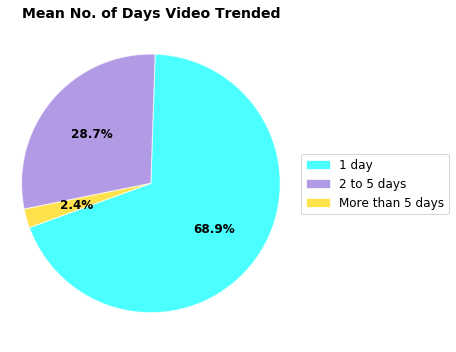

In [134]:
#display the findings for segmentation: mean number of days video trended

_=plt.figure(figsize=(6,5))

# Labels for the sections of our pie chart
labels = ["1 day", "2 to 5 days", "More than 5 days"]

# The values of each section of the pie chart
sizes = combined_per_video_df["Days Trended Segment"].value_counts()

# The colors of each section of the pie chart
#colors = [plt.cm.Blues(0.4), plt.cm.Purples(0.4), plt.cm.Greens(0.4)]
colors = ["cyan",  "mediumpurple", "gold"]

#Display
_=plt.pie(sizes,  
        colors=colors, autopct="%1.1f%%", shadow=False, 
        startangle=200, wedgeprops={'edgecolor':'w', "alpha" : 0.7}, 
        textprops={"fontsize": 12, "color":'black', "fontweight":'bold'})

#formatting
_=plt.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
_=plt.title("Mean No. of Days Video Trended", fontsize=14, fontweight='bold')
_=plt.tight_layout()
_=plt.axis("equal")

_=plt.savefig('../Image/Mean_No.of_Days_Video_Trended.png', 
            bbox_inches = "tight" )
plt.show()



### Finding2

**Insight: The vast majority (92.5%) of videos trended in a single country.**  

Approach: Remove duplicates so that dataset contains 1 row per video_id per country, and count the no. of rows per video_id. 



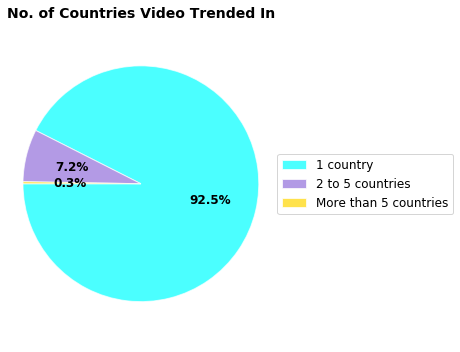

In [135]:
#display the findings for segmentation: number of countries trended in 

_=plt.figure(figsize=(6,5))

# Labels for the sections of our pie chart
labels = ["1 country", "2 to 5 countries", "More than 5 countries"]

# The values of each section of the pie chart
sizes = combined_per_video_df["Country Segment"].value_counts()

# The colors of each section of the pie chart
#colors = [plt.cm.Blues(0.4), plt.cm.Purples(0.4), plt.cm.Greens(0.4)]
colors = ["cyan",  "mediumpurple", "gold"]

#Display
_=plt.pie(sizes,  
        colors=colors, autopct="%1.1f%%", shadow=False, 
        startangle=180, wedgeprops={'edgecolor':'w', "alpha" : 0.7}, 
        textprops={"fontsize": 12, "color":'black', "fontweight":'bold'})

#formatting
_=plt.title("No. of Countries Video Trended In", fontsize=14, fontweight='bold')
_=plt.legend(labels, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
_=plt.tight_layout()
_=plt.axis("equal")

_=plt.savefig('../Image/No._of_Countries_Video_Trended_In.png', 
            bbox_inches = "tight" )

plt.show()

### Finding3

**Insight: The more countries videos trended in, the greater the proportion that trend for more than a single day.**   

Approach: 
- Create segments based on the above categories and incorporate into dataframe (df: Remove duplicates so that dataset contains 1 row per video_id per country).
- Group by video_id and Days_trending segment and count by countries_trended_in segment.
- Determine percentage of total per countries_trended_in segment. 
- Plot table (Mean Days Trending by No. of countries trended in) 

,Single Day(%),Two to Five Days(%),More than five Days(%)
Country Segment,,,
Trended in 1 country,71.774113,26.603777,1.622110
Trended in 2 to 5 countries,34.607828,54.526220,10.865951
Trended in more than 5 countries,5.436893,64.854369,29.708738


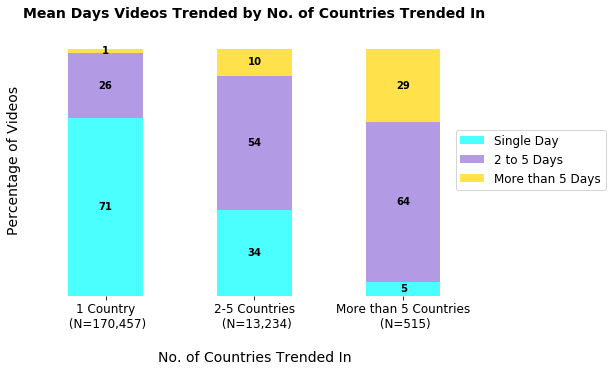

In [136]:
#Table: Mean Days Trending by No. of countries trended in 
country_trended_percentage_df

#create stacked bar chart - by countries segment

colors=["cyan",  "mediumpurple", "gold" ]
labels=[f"1 Country\n (N=170,457)", 
        "2-5 Countries\n (N=13,234)", 
        "More than 5 Countries\n (N=515)"]
legend_labels=["Single Day", "2 to 5 Days", "More than 5 Days"]
                                   
ax = country_trended_percentage_df.plot(kind="bar", 
                                   stacked=True, 
                                   color=colors,
                                        alpha=0.7,
                                   figsize=(8,5),
                                   fontsize=12,
                                   rot=0,
                                   ylim=(0,110))

#Formatting                                  
_=ax.set_frame_on(False)  

                                     
_=ax.set_xticklabels(labels)
                         
_=ax.set_yticklabels([])
_=ax.set_yticks([])

_=ax.set_xlabel("No. of Countries Trended In", 
              fontsize=14, 
              labelpad=20)

_=ax.set_ylabel("Percentage of Videos", 
              fontsize=14, 
              labelpad=10)

_=ax.set_title("Mean Days Videos Trended by No. of Countries Trended In", 
             fontsize=14,
             fontweight='bold')

_=plt.legend(legend_labels, 
           loc="center right", 
           bbox_to_anchor=(1.3, 0.5),
           fontsize=12)

#data labels
for rect in ax.patches:
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    padding = 0.25
    label_text = int(height)
    
    label_x = x + width - padding
    label_y = y + height / 2
    
    _=ax.text(label_x, label_y, label_text, 
            ha='center', va='center',
           fontweight = "bold")
    
#ax.patches

plt.savefig('../Image/Mean_Days_Videos_Trended_by_No._of_Countries_Trended_In.png', 
            bbox_inches = "tight" )

plt.show()

### Finding4

Insight: 
- For six of ten countries, the majority of videos trend for a single days. 
- In Korea, just under half of videos trend for 2 to 5 days whereas over half of videos in India trended for that interval. 
- US and UK are outliers amoung the countries as the majority of videos that trended in these countries did so for more than five days.   

Approach:  
- Count no. of days a video trended by country. Count no. of videos per days_trending segment per country. Determine percentage of total per country. 
- Plot table (Days Trending by Country)     


,Single Day(%),Two to Five Days(%),More than Five Days(%)
country,,,
JP,88.605534,11.394466,0.000000
RU,84.489903,15.510097,0.000000
MX,83.700585,16.299415,0.000000
FR,75.198796,24.797932,0.003272
DE,72.258805,27.734441,0.006754
CA,59.432107,39.986069,0.581824
IN,47.994111,50.625690,1.380199
KR,39.098076,60.372122,0.529801
US,11.140876,37.015443,51.843681


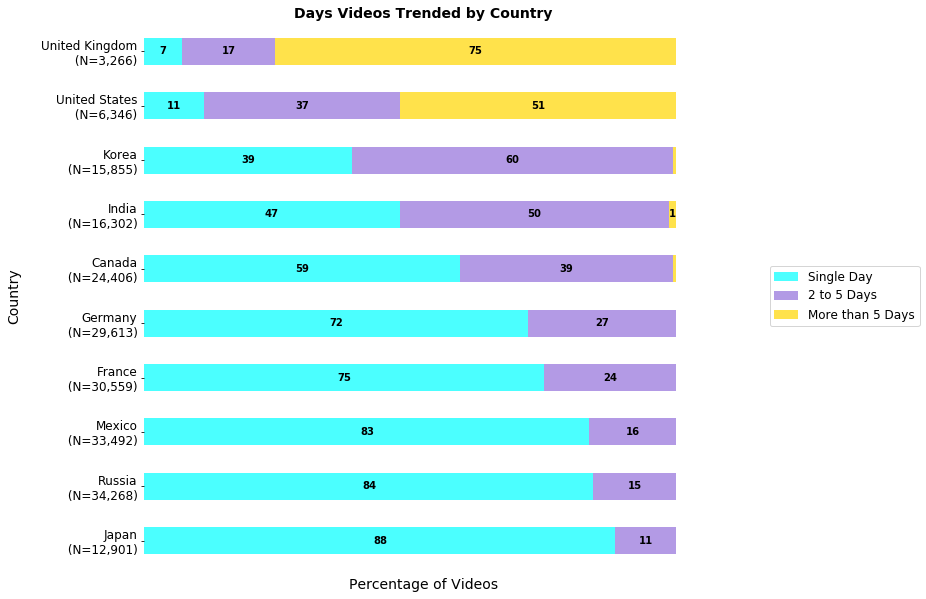

In [137]:
#Table: Days Trending by Country
country_percentage_df.sort_values(by="Single Day(%)", ascending=False, inplace=True)
country_percentage_df

#create stacked bar chart - by individual countries
colors1=["cyan",  "mediumpurple", "gold" ]
labels1=["Japan\n (N=12,901)",
        "Russia\n (N=34,268)",
        "Mexico\n (N=33,492)",
        "France\n (N=30,559)",
        "Germany\n (N=29,613)",
        "Canada\n (N=24,406)", 
        "India\n (N=16,302)",
        "Korea\n (N=15,855)",
        "United States\n (N=6,346)",
        "United Kingdom\n (N=3,266)"]

legend_labels1=["Single Day", "2 to 5 Days", "More than 5 Days"]
                                   
ax1 = country_percentage_df.plot(kind="barh", 
                                   stacked=True, 
                                   color=colors,
                                   alpha=0.7,
                                   figsize=(10,10),
                                   fontsize=12,
                                   rot=0)                      

#Formatting                                  
_=ax1.set_frame_on(False)  
                                     
_=ax1.set_yticklabels(labels1)
                         
_=ax1.set_xticks([])

_=ax1.set_ylabel("Country", 
              fontsize=14, 
              labelpad=20)

_=ax1.set_xlabel("Percentage of Videos", 
              fontsize=14, 
              labelpad=10)

_=ax1.set_title("Days Videos Trended by Country", 
             fontsize=14,
             fontweight='bold')

_=plt.legend(legend_labels, 
           loc="center right", 
           bbox_to_anchor=(1.4, 0.5),
           fontsize=12)

#data labels
for rect in ax1.patches:
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    padding = 0.25
    label_text = (int(width) if int(width)!=0 else "")
    
    label_x = x + width - padding
    label_y = y + height / 2
    
    label_x = x + width/2
    label_y = y + height - padding
    
    _=ax1.text(label_x, label_y, label_text, 
            ha='center', va='center',
           fontweight = "bold")
    

_=plt.savefig('../Image/Days_Videos_Trended_by_Country.png', 
            bbox_inches = "tight" )

plt.show()

## Analysis:  Do certain countries tend to trend the same videos? 

### Data Manipulation for analysis

In [138]:
#counts days trending (doing this separate from other analysis due to other index resets causing incorrect findings)

#bring country segmentation into originally dataframe
holder = Total_DF 

holder.set_index("video_id", inplace=True)

holder["Countries Trended in Segment"] = combined_per_video_df["Country Segment"]

#create dataframe containing only those videos that trended in 
multi_country_df = holder.loc[holder["Countries Trended in Segment"]!= "Trended in 1 country",:]

#find first day to trend per each country
First_day_trended_by_country = multi_country_df.groupby(
    ['video_id',"country"]).aggregate(
    First_Trend_Date=('trending_date', 'min'))

First_day_trended_by_country.reset_index(inplace=True)

# count no. of videos first trended in various counties on the same date/different dates
First_dates=First_day_trended_by_country.groupby(["video_id", "First_Trend_Date"]).count().reset_index()

First_dates_counts_by_id = First_dates.groupby("video_id")["First_Trend_Date"].count()

Final_First_dates_counts_by_id = First_dates_counts_by_id.reset_index()

Final_First_dates_counts_by_id.rename(columns={"First_Trend_Date": "no of unique first trend dates"}, inplace=True)

Final_First_dates_counts_by_id

### Finding5

Insight: 
- Videos that trended in multiple countries most often trended in Canada (over 1 in 4) followed by Germany (over 1 in 5) and France (just under 1 in 6). 
- Few Videos that trended in multiple countries trend in the US, suggesting it has less impact on trending in other countries. 

Approach: 
- Create a dataframe only containing videos that trended in 2+ countries. Remove duplicates such as there was only 1 row per video_id per country, and count the number of videos per country.  



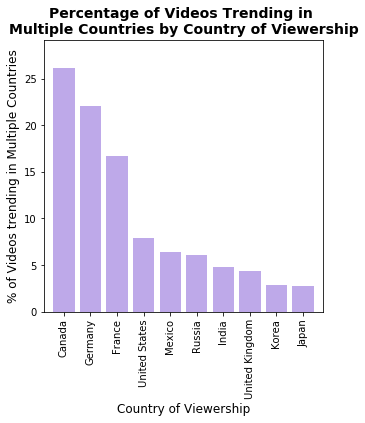

In [141]:
#display the findings for where videos, that trended in multiple countries, trend

#prep labels

labels2 = ["Canada", 
           "Germany",
           "France",
           "United States",
           "Mexico",
           "Russia",
           "India",
           "United Kingdom",
            "Korea",
            "Japan"]

#setup axis
x = np.arange(len(labels2))
y= First_day_trended_by_country["country"].value_counts()*100/First_day_trended_by_country["country"].count()

#plot
_=plt.figure(figsize=(5,5))

ax3 = plt.bar(x, 
        y, 
        color='mediumpurple', 
        alpha=0.6, 
        align="center")

#formatting
tick_locations = [value for value in x]

_=plt.xticks(tick_locations, labels2, rotation=90)

_=plt.xlim(-0.75, len(x)-0.25)

_=plt.ylim(0, max(y)+3)

_=plt.title("Percentage of Videos Trending in \nMultiple Countries by Country of Viewership",
         fontsize=14, fontweight='bold')
_=plt.xlabel("Country of Viewership", fontsize=12)
_=plt.ylabel("% of Videos trending in Multiple Countries", fontsize=12)

_=plt.savefig('../Image/Percentage_of_Videos_Trending_in_Multiple_Countries_by_Country_of_Viewership.png', 
            bbox_inches = "tight" )

plt.show()

### Finding6

Insights:

- Just under 8 in 10 videos that trended in multple countries first did so on same day across countries. This suggests that there is no single regional origin of trending for the majority of videos that trend in multiple countries.  

Approach: 
- Create a dataframe only containing videos that trended in 2+ countries. Determine first day of trending per video per country, and put in lists per video_id containing only unique dates. Count the lengths of lists to determine no. of unique first days.

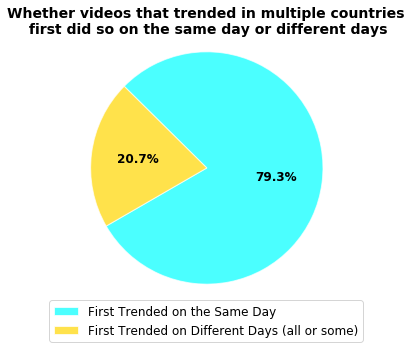

In [142]:
#display the findings for segmentation: number of countries trended in 

_=plt.figure(figsize=(6,5))

    #stratify dataset
same_day = Final_First_dates_counts_by_id.loc[Final_First_dates_counts_by_id["no of unique first trend dates"]==1, :]
multiple_days = Final_First_dates_counts_by_id.loc[Final_First_dates_counts_by_id["no of unique first trend dates"]>1, :]

    #visualize
# Labels for the sections of our pie chart
labels = ["First Trended on the Same Day", "First Trended on Different Days (all or some)"]

# The values of each section of the pie chart

sizes = [len(same_day)/Final_First_dates_counts_by_id["video_id"].count(), 
         len(multiple_days)/Final_First_dates_counts_by_id["video_id"].count()]

# The colors of each section of the pie chart
#colors = [plt.cm.Blues(0.4), plt.cm.Purples(0.4), plt.cm.Greens(0.4)]
colors = ["cyan", "gold"]

#Display
_=plt.pie(sizes, colors=colors, autopct="%1.1f%%",
        shadow=False, startangle=210, 
        wedgeprops={'edgecolor':'w', "alpha" : 0.7}, 
        textprops={"fontsize": 12, "color":'black', "fontweight":'bold'})

#formatting
_=plt.title("Whether videos that trended in multiple countries\n first did so on the same day or different days", 
          fontsize=14, fontweight='bold')
_=plt.legend(labels, loc="lower center", bbox_to_anchor=(0.5, -0.2), fontsize=12)
_=plt.tight_layout()
_=plt.axis("equal")

_=plt.savefig('../Image/Whether_videos_that_trended_in_multiple_countries_first_did_so_on_the_same_day_or_different_days.png', 
            bbox_inches = "tight" )
plt.show()

## Analysis:  Where do video originate from? 

### Data Manipulation for analysis

In [143]:
#Replace NaN with string to capture channels with unknown origins in the total

ultimate_df["Country Origin"].fillna("Unknown", inplace=True)

dedup_ultimate_df = ultimate_df.drop_duplicates(subset=['video_id', 'country'], keep='first')

#find top 10 origins of channels

Channel_origins = dedup_ultimate_df["Country Origin"].value_counts().head(12).reset_index()

counts= Channel_origins["Country Origin"].tolist()

### Finding7

Insights:

- Most video have an unknown origin. Of those that do, the highest proportion originate from the US.    

Approach: 
- create a dataframe with a single row per country per video_id, counted the no. of channels by origin and display up to countries of interest.

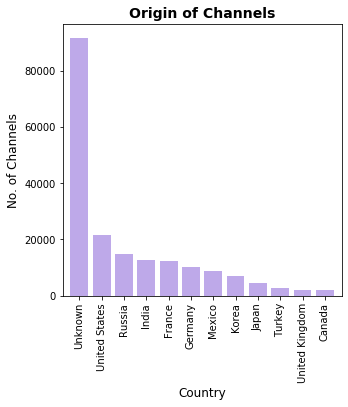

In [144]:
#display the findings for where videos, that trended in multiple countries, trend

#prep labels

labels3 = ["Unknown", 
           "United States",
           "Russia",
           "India",
           "France",
           "Germany",
           "Mexico",
           "Korea",
           "Japan",
           "Turkey",
           "United Kingdom",
           "Canada"]
       
#setup axis
x = np.arange(len(labels3))

#plot
_=plt.figure(figsize=(5,5))

ax3 = plt.bar(x, 
        counts, 
        color='mediumpurple', 
        alpha=0.6, 
        align="center")

#formatting
tick_locations_1 = [value for value in x]

_=plt.xticks(tick_locations_1, labels3, rotation=90)

_=plt.xlim(-0.75, len(x)-0.25)

_=plt.ylim(0, max(counts)+5000)

_=plt.title("Origin of Channels", fontsize=14, fontweight='bold')
_=plt.xlabel("Country", fontsize=12)
_=plt.ylabel("No. of Channels", fontsize=12)

_=plt.savefig('../Image/Origin_of_Channels.png', 
            bbox_inches = "tight" )
plt.show()

### Finding8

Insights
- Canada, Germany and France watch videos originating from over 80 known countries.  

Approach
- Create a dataframe with 1 row per video_id pre country. Count the number of channel origins by country.   

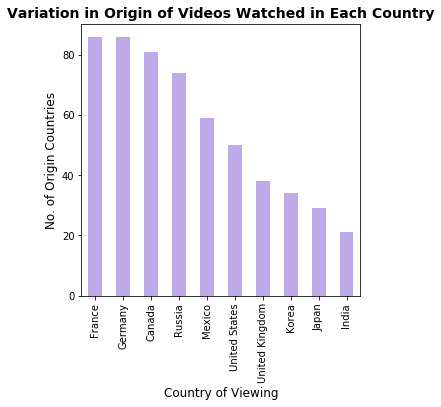

In [145]:
#country of origin counts

#create a dataframe with one row per video per country
one_per_video = ultimate_df.drop_duplicates(
    subset=["video_id", "country"], keep="first")

origin_counts_by_country_watched = one_per_video.groupby("country")["Country Origin"].value_counts().unstack()


#origin_counts_by_country_watched_unstacked= origin_counts_by_country_watched.unstack()

#prep labels

labels4 = ["France",
           "Germany",
           "Canada", 
           "Russia",
           "Mexico",
           "United States",
           "United Kingdom",
           "Korea",
           "Japan",
           "India"]
       
#setup axis
x = np.arange(len(labels4))

#plot
_=plt.figure(figsize=(5,5))

ax4 = origin_counts_by_country_watched.count(axis=1).sort_values(ascending=False). plot(kind="bar",        
                                                          color='mediumpurple', 
                                                          alpha=0.6)

#formatting
tick_locations_2 = [value for value in x]

_=plt.xticks(tick_locations_2, labels4, rotation=90)

_=ax4.set_title("Variation in Origin of Videos Watched in Each Country", 
              fontsize=14, fontweight='bold')
_=ax4.set_xlabel("Country of Viewing", fontsize=12)
_=ax4.set_ylabel("No. of Origin Countries", fontsize=12)

_=plt.savefig('../Image/Variation_in_Origin_of_Videos_Watched_in_Each_Country.png', 
            bbox_inches = "tight" )

plt.show()

### Finding9

Approach:

- convert count of number of channel country origins by country into percentages.     

Insights:

- Canada and the UK watched little content known to originate from within the respective countries, rather most videos watched in these countries orignate in the US. Comparatively, most videos watched in other countries originate from within the respective countries.     

In [148]:
#create dataframe containing breakdown of origin by country viewed

source_focused = pd.DataFrame({
                              "CA (%)" : origin_counts_by_country_watched["CA"]*100/origin_counts_by_country_watched.sum(axis=1),
                              "DE (%)" : origin_counts_by_country_watched["DE"]*100/origin_counts_by_country_watched.sum(axis=1),
                              "FR (%)" : origin_counts_by_country_watched["FR"]*100/origin_counts_by_country_watched.sum(axis=1),
                              "GB (%)" : origin_counts_by_country_watched["GB"]*100/origin_counts_by_country_watched.sum(axis=1),
                              "IN (%)" : origin_counts_by_country_watched["IN"]*100/origin_counts_by_country_watched.sum(axis=1),
                              "JP (%)" : origin_counts_by_country_watched["JP"]*100/origin_counts_by_country_watched.sum(axis=1),
                              "KR (%)" : origin_counts_by_country_watched["KR"]*100/origin_counts_by_country_watched.sum(axis=1),
                              "MX (%)" : origin_counts_by_country_watched["MX"]*100/origin_counts_by_country_watched.sum(axis=1),
                              "RU (%)" : origin_counts_by_country_watched["RU"]*100/origin_counts_by_country_watched.sum(axis=1),
                              "US (%)" : origin_counts_by_country_watched["US"]*100/origin_counts_by_country_watched.sum(axis=1)})
                             

source_focused.fillna(value=0, inplace=True)

source_focused

,CA (%),DE (%),FR (%),GB (%),IN (%),JP (%),KR (%),MX (%),RU (%),US (%)
country,,,,,,,,,,
CA,5.236417,0.143407,2.351881,2.679669,4.916824,0.094239,0.700647,0.020487,0.249939,33.876916
DE,0.401851,33.799345,0.097930,1.246074,1.337251,0.023638,0.104684,0.000000,1.874177,8.178840
FR,0.759187,0.193069,37.929906,0.769004,1.852155,0.094898,0.193069,0.003272,0.055630,4.211525
GB,1.285977,0.275566,0.183711,10.287814,0.061237,0.459277,1.469688,0.000000,0.030618,36.037967
IN,0.251503,0.055208,0.055208,0.153355,63.777451,0.000000,0.000000,0.000000,0.006134,3.600785
JP,0.046508,0.023254,0.062011,0.139524,0.077513,32.237811,1.054182,0.000000,0.000000,1.635532
KR,0.100915,0.044150,0.000000,0.151372,0.132450,0.170293,40.182908,0.000000,0.018921,1.570482
MX,0.322465,0.032844,0.020901,0.229906,0.077630,0.226920,0.161233,26.439150,0.110474,8.613997
RU,0.195518,0.341426,0.087545,0.221781,0.148827,0.137154,0.087545,0.000000,41.604412,4.231353


<function matplotlib.pyplot.show(*args, **kw)>

<Figure size 720x720 with 0 Axes>

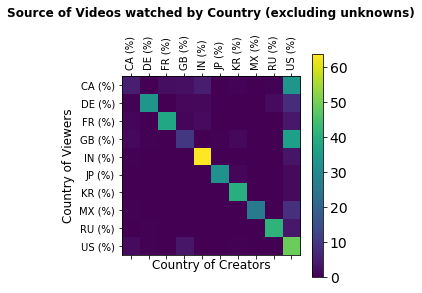

In [149]:
_=plt.figure(figsize=(10, 10))
_=plt.matshow(source_focused, )
_=plt.xticks(range(source_focused.shape[1]), source_focused.columns, fontsize=10, rotation=90)
_=plt.yticks(range(source_focused.shape[1]), source_focused.columns, fontsize=10)
cb = plt.colorbar()
_=cb.ax.tick_params(labelsize=14)

ttl = plt.title('Source of Videos watched by Country (excluding unknowns)', 
                fontsize=12, fontweight='bold')
_=ttl.set_position([0.5, 1.3])

_=plt.ylabel("Country of Viewers", fontsize=12)
_=plt.xlabel("Country of Creators", fontsize=12)

_=plt.savefig('../Image/Source_of_Videos_watched_by_Country.png', 
            bbox_inches = "tight" )

plt.show

# Problem formulation on popularity

##  What is typically the pattern of trend ? Is it continuous trending or sporadic ?

Insight:
- Trending pattern is continuous
- A very high correlation (0.986) between the total trend days and the maximum of  continuous trend days show Trending is a continuous pattern. 

- Also, 99% of the trendings was continuous without a break and only 1% had a break in trending

22

Trending_Dates Trending_Dates_String  \
video_id    country                                                
--1skHapGUc MX       [2018-02-10 00:00:00]            [18.10.02]   
--2K8l6BWfw FR       [2018-03-06 00:00:00]            [18.06.03]   
--45ws7CEN0 CA       [2018-06-12 00:00:00]            [18.12.06]   
            MX       [2018-06-12 00:00:00]            [18.12.06]   
            RU       [2018-06-12 00:00:00]            [18.12.06]   

                     Max_Period_of_Cont_Treanding  
video_id    country                                
--1skHapGUc MX                                  1  
--2K8l6BWfw FR                                  1  
--45ws7CEN0 CA                                  1  
            MX                                  1  
            RU                                  1

,,First_Trend_Date,Last_Trend_Date,Trending_Dates_String,Total_Trend_Days,Max_Period_of_Cont_Treanding
video_id,country,,,,,
-3VBPAZPTQI,GB,2017-12-31,2018-01-15,"[17.31.12, 18.01.01, 18.02.01, 18.03.01, 18.04...",14,10
-8X32zNup1o,GB,2018-05-23,2018-06-11,"[18.23.05, 18.04.06, 18.05.06, 18.06.06, 18.07...",9,8
-BDImdAfodA,GB,2018-02-02,2018-03-07,"[18.02.02, 18.03.02, 18.04.02, 18.05.02, 18.06...",32,29
-DRsfNObKIQ,GB,2018-05-12,2018-06-14,"[18.12.05, 18.13.05, 18.15.05, 18.16.05, 18.17...",33,31
-F9cQpO-Pdw,CA,2018-05-13,2018-05-15,"[18.13.05, 18.15.05]",2,1


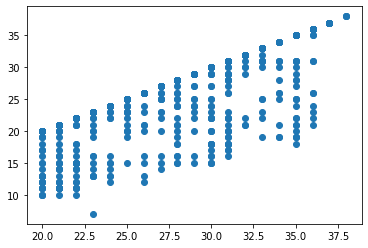

(0.9869677068193605, 0.0)

99.20969237903849

0.7903076209615087

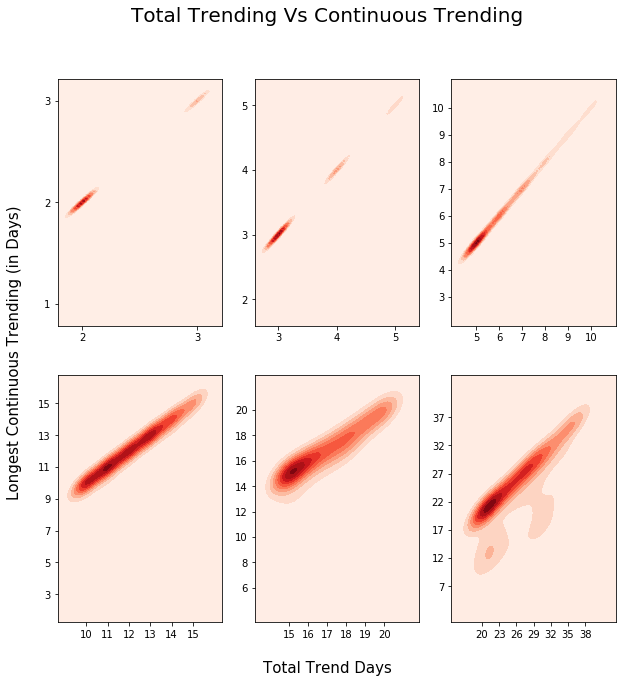

In [193]:
Video_DF = pd.read_pickle("../Data/VideoDF.pkl")

## Derive Total Trending Days
Trending_Days = Video_DF.groupby(['video_id', 'country']).aggregate(First_Trend_Date=('trending_date', 'min'), Last_Trend_Date=('trending_date', 'max'), Total_Trend_Days=('trending_date', 'count'))
#Trending_Days.head()

## Continuity of Trending
Sorted_Video_Country_DF = Video_DF.sort_values(by=['video_id', 'country', 'trending_date']) 
Video_Country_grp = Sorted_Video_Country_DF.groupby(['video_id', 'country']) #Sorting is done to get the list of dates in order
Video_Country_Wise_Trending_Dates = Video_Country_grp.aggregate(Trending_Dates = ('trending_date', lambda x: x.to_list()))

#Maximum Continuous Days of Trending
def find_max_period(dates):
    period=1
    max_periods = 1
    for index, date in enumerate(dates[:-1]):
        diff = dates[index+1] - date
        
        if diff.days == 1:
            period+=1
        else:
            if max_periods < period:
                max_periods = period
            period=1
        
    return (max_periods if max_periods>period else period)
find_max_period(Video_Country_Wise_Trending_Dates.loc[('zxwfDlhJIpw', 'GB'), :][0])
Video_Country_Wise_Trending_Dates['Max_Period_of_Cont_Treanding'] = Video_Country_Wise_Trending_Dates.apply(lambda x: find_max_period(x[0]), axis=1)
Video_Country_Wise_Trending_Dates['Trending_Dates_String'] = Video_Country_Wise_Trending_Dates['Trending_Dates'].map(lambda L: [item.strftime("%y.%d.%m") for item in L])            
Video_Country_Wise_Trending_Dates = Video_Country_Wise_Trending_Dates[['Trending_Dates', 'Trending_Dates_String', 'Max_Period_of_Cont_Treanding']]                             
Video_Country_Wise_Trending_Dates.head()

## Merge Total_Trend_Days and Max_Period_of_Cont_Treanding into a single DF
Trending_Pattern_DF = Trending_Days.join(Video_Country_Wise_Trending_Dates[['Trending_Dates_String', 'Max_Period_of_Cont_Treanding']])
Trending_Pattern_DF = Trending_Pattern_DF[['First_Trend_Date', 'Last_Trend_Date', 'Trending_Dates_String', 'Total_Trend_Days','Max_Period_of_Cont_Treanding']]


#Trending_Pattern_DF[Trending_Pattern_DF['Total_Trend_Days']==Trending_Pattern_DF['Max_Period_of_Cont_Treanding']].head()
Trending_Pattern_DF[Trending_Pattern_DF['Total_Trend_Days']!=Trending_Pattern_DF['Max_Period_of_Cont_Treanding']].head()

## Plotting to demonstrate correlation
#Scatter plot doesn't capture density
above = 20 
below = Trending_Pattern_DF['Total_Trend_Days'].value_counts().index.max()
Target = Trending_Pattern_DF[(Trending_Pattern_DF['Total_Trend_Days']>=above) & (Trending_Pattern_DF['Total_Trend_Days']<=below)]

x = Target['Total_Trend_Days']
y = Target['Max_Period_of_Cont_Treanding']
_=plt.figure()
_=plt.scatter(x,y)
_=plt.show()

#Hence, we use kde plot of seaborn
above_below = [2,3,5,10,15,20,Trending_Pattern_DF['Total_Trend_Days'].value_counts().index.max()]

fig, axes = plt.subplots(2,3, figsize=(10,10))
Axes = axes.flat

for index, val in enumerate(above_below[:-1]):
    above =  val
    below = above_below[index+1]
    Target = Trending_Pattern_DF[(Trending_Pattern_DF['Total_Trend_Days']>=above) & (Trending_Pattern_DF['Total_Trend_Days']<=below)]

    
    x = Target['Total_Trend_Days']
    y = Target['Max_Period_of_Cont_Treanding']
    
    _ = sns.kdeplot(x,y, cmap="Reds", shade=True, ax=Axes[index])

    #Disable individual labels
    _=Axes[index].set_xlabel('')
    _=Axes[index].set_ylabel('')
    
    #Custom xticks
    stepx = (1 if len(range(x.min(), x.max()+1))<=6 else  len(range(x.min(), x.max()+1))//6)
    stepy = (1 if len(range(y.min(), y.max()+1))<=6 else  len(range(y.min(), y.max()+1))//6)
    
    _=Axes[index].set_xticks(list(range(x.min(), x.max()+1, stepx)))
    _=Axes[index].set_yticks(list(range(y.min(), y.max()+1, stepy)))
    
#Common Labels
_ = fig.suptitle('Total Trending Vs Continuous Trending', fontsize=20)
_ = fig.text(0.5, 0.055, 'Total Trend Days', ha='center', fontsize=15)
_ = fig.text(0.055, 0.5, 'Longest Continuous Trending (in Days)', va='center', rotation='vertical', fontsize=15)

#Save figure
fig.savefig('../Image/Total_Trending_Vs_Continuous_Trending.png')

## Find the correlation between Max_Perid_of_Cont_Treanding ("Popularity") Vs. Total_Trend_Days
st.pearsonr(Trending_Pattern_DF['Total_Trend_Days'], Trending_Pattern_DF['Max_Period_of_Cont_Treanding'])

#Percentge wise comparison on continuity
100*Trending_Pattern_DF[Trending_Pattern_DF['Total_Trend_Days']==Trending_Pattern_DF['Max_Period_of_Cont_Treanding']].shape[0]/Trending_Pattern_DF.shape[0]

100*Trending_Pattern_DF[Trending_Pattern_DF['Total_Trend_Days']!=Trending_Pattern_DF['Max_Period_of_Cont_Treanding']].shape[0]/Trending_Pattern_DF.shape[0]

### NOTE
Our initial data set has 360217 trending videos (including multiple occuraces of some of the trending videos). However, only a subset of videos were returned through API call(266546 videos, including multiple occuraces of some of the trending videos). We are keeping only this subset for our feature studies as keeping the original set is sparse with multiple NaN values. Unless otherwise mentioned, the shorter(na removed) version of the data will be used for analysis. Please note that we have compared the analysis on both the Data wherever possible and they produce similar results 

In [197]:
DF1 = pd.read_pickle("../Data/New_Video_DF_360217.pkl")
DF = pd.read_pickle("../Data/Cleaned_Data(No_Agg).pkl")

Data_Lost = pd.DataFrame(DF1['country'].value_counts()).join(DF['viewing_country'].value_counts())
Data_Lost.columns=['Before', 'After']
Data_Lost['%Loss']=100*Data_Lost['After']/Data_Lost['Before']

Data_Lost

Data_Original = pd.DataFrame(100*Data_Lost['Before'].copy()/Data_Lost['Before'].sum())
Data_Original.columns=['% of occupation in data']
Data_Original['Total'] = Data_Lost['Before']

Data_Selected = pd.DataFrame(100*Data_Lost['After'].copy()/Data_Lost['After'].sum())
Data_Selected.columns=['% of occupation in data']
Data_Selected['Total'] = Data_Lost['After']

,Before,After,%Loss
US,40859,36783,90.024230
CA,40834,32753,80.210119
DE,40812,30985,75.921298
FR,40690,29274,71.943967
RU,40101,28592,71.299968
MX,39857,24316,61.008104
GB,38663,33643,87.016010
IN,32252,24667,76.482079
KR,31715,17945,56.582059
JP,14434,7588,52.570320


## How Language affects Trending ?

* **As we would expect, The local language seems to play a big role in trending**
* **We studies the ratio of languages of trending videos across countries (English is Top3 for all except Russia, Japan and Korea)**
* **Only in Great Britain and United States, videos trend significantly more than other countries. Similarly,  English videos trend significantly more than other languages**

In [198]:
DF = pd.read_pickle("../Data/Cleaned_Data(No_Agg).pkl")
DF['Lang'].fillna('Unknown', inplace=True)
DF['Lang'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)

package = Package('https://datahub.io/core/country-list/datapackage.json')

# print list of all resources:
#print(package.resource_names)

### Country Code to Country Mapping (Helper Function)
# print processed tabular data (if exists any)
for resource in package.resources:
    if resource.descriptor['datahub']['type'] == 'derived/csv':
        content = resource.read()
ISO_Alpha2_Country_Mapping = {item[1]:item[0] for item in content}
ISO_Alpha2_Country_Mapping['KR']='Korea' #From 'Korea, Republic of' to Korea

### Which Language Trended the most in which countries?




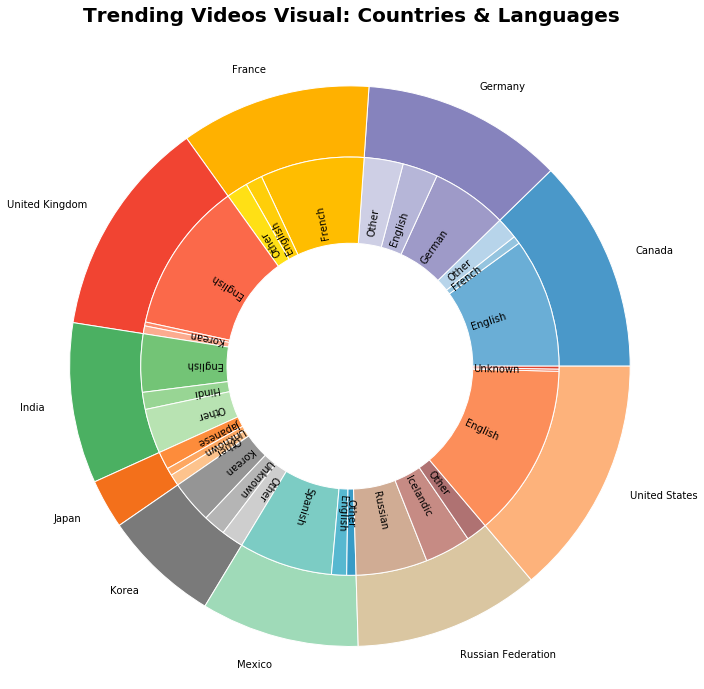

In [199]:
Country_Vs_Lang_Table = DF.groupby(['viewing_country', 'Lang'])['video_id'].count().unstack()
Country_Vs_Lang_Table = Country_Vs_Lang_Table.fillna(value=0).astype('int64')

def toppers(x, how_many=3):
    toppers = {key:x.to_dict()[key] for key in sorted(x.to_dict(), key=lambda y: x.to_dict()[y], reverse=True)[:how_many]}
    toppers.update({'Other':x.sum() - sum(toppers.values())})
    return toppers

Outer = Country_Vs_Lang_Table.sum(axis=1)

Inner = Country_Vs_Lang_Table.apply(lambda x:toppers(x,2), axis=1)  


##Plot pie chart
fig, axis = plt.subplots(figsize = (10,10))
_=axis.axis('equal')
color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges , plt.cm.Greys, plt.cm.GnBu_r, plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

#Outer pie
labels = [ISO_Alpha2_Country_Mapping[cc] for cc in Outer.index]
pie1= axis.pie(Outer, labels=labels, colors=colors,radius=1.3)  
_=plt.setp(pie1[0], width=0.33, edgecolor='white' )

#Inner pie
names = list(np.array([list(item) for item in Inner.map(lambda x: x.keys()).to_list()]).flatten())
values = list(np.array([list(item) for item in Inner.map(lambda x: x.values()).to_list()]).flatten())
colors = []
for color in color_range:
    colors = colors + [color(i) for i in [0.5,0.4,0.3]]
pie2 = axis.pie(values, radius=1.3-.33, labels=names, labeldistance=0.7, colors=colors)
_=plt.setp(pie2[0], width=0.4, edgecolor='white')
_=plt.margins(0,0)

# do the rotation of the labels
for w, t in zip(pie2[0], pie2[1]):
    mang =(w.theta1 + w.theta2)/2.  # get mean_angle of the wedge
    #print(mang, t.get_rotation())
    _=t.set_rotation(mang)         # rotate the label by (mean_angle)
    _=t.set_va("center")
    _=t.set_ha("center")

#Tiding up the clutter
_=pie2[1][11].set_visible(False)
_=pie2[1][-1].set_visible(False)

_=plt.suptitle('Trending Videos Visual: Countries & Languages', fontsize=20, weight='bold', y=1)
_=plt.tight_layout()
_=axis.axis('equal')
_= plt.savefig('../Image/Lang1.png', bbox_inches = "tight" )
_=plt.show()

## Is there any difference in popularity for trending (longevity) across countries ?

* **Only in Great Britain and United States, videos trend significantly more than other countries. Similarly,  English videos trend significantly more than other languages**

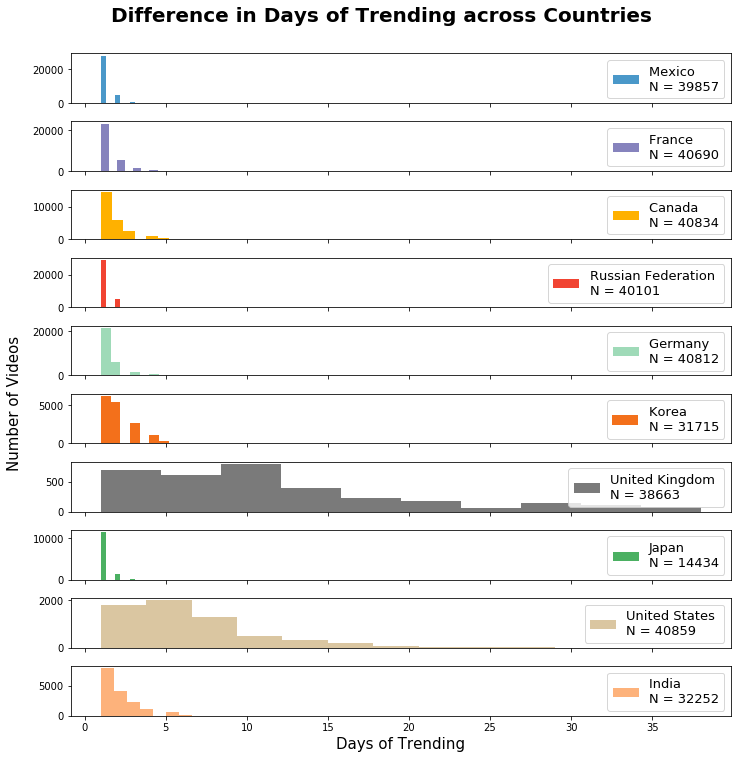

In [204]:
DF = DF1.groupby(['video_id', 'country'])['trending_date'].count().reset_index()
DF.columns = ['video_id','viewing_country','Total_Trend_Days']

List_of_CCs = DF['viewing_country'].unique()

fig, axs = plt.subplots(10, 1, sharex=True, sharey=False, tight_layout=True, figsize=(10,10))

color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,cc in enumerate(List_of_CCs):
    _=axs[index].hist(DF[DF['viewing_country']==cc]['Total_Trend_Days'], color=colors[index], alpha=1, label=f"{ISO_Alpha2_Country_Mapping[cc]} \nN = {Data_Original.loc[cc, 'Total']}")

    #legend
    _=axs[index].legend(loc='upper right', fontsize = 13)
    

    
_=plt.suptitle('Difference in Days of Trending across Countries', fontsize=20, weight='bold', y=1.05) 
#xlabel, ylabel
_=plt.xlabel('Days of Trending',fontsize = 15)
_=fig.text(-0.02, 0.5, 'Number of Videos', va='center', rotation='vertical', fontsize = 15)


_ = plt.tight_layout()
_= plt.savefig('../Image/Popularity_Across_Countries_with_360217.png', bbox_inches = "tight" )
plt.show()

## Is there any difference in popularity for trending (longevity) across languages ?

* **English videos trend significantly more than other languages**

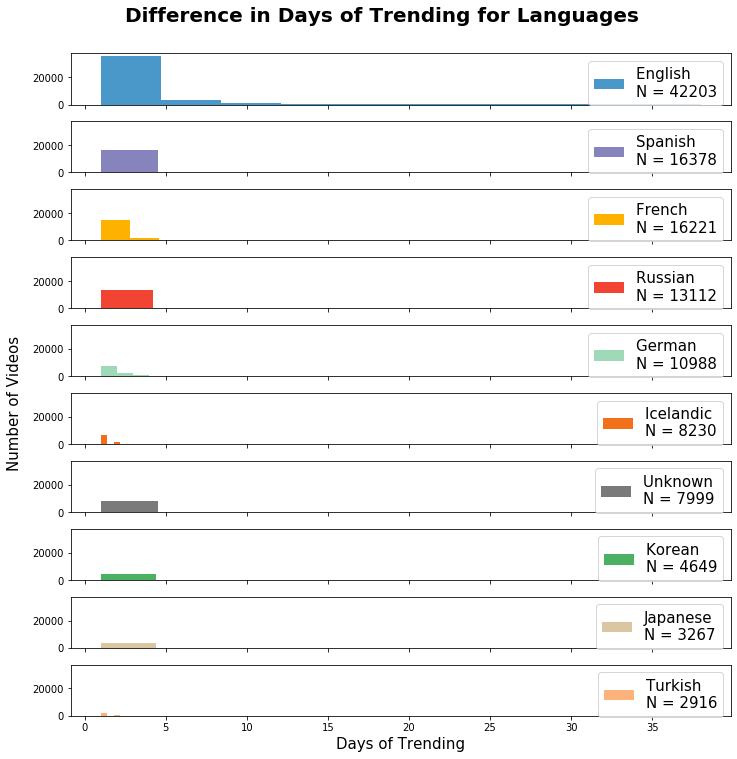

In [205]:
DF = pd.read_pickle('../Data/Popularity_DF.pkl')

DF['Language'].fillna('Unknown', inplace=True)
DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)
Language_Count = pd.DataFrame(DF['Language'].value_counts())


Top10 = Language_Count.index[:10]

fig, axs = plt.subplots(10, 1, sharex=True, sharey=True, tight_layout=True, figsize=(10,10))

color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,lang in enumerate(Top10):
    _=axs[index].hist(DF[DF['Language']==lang]['Total_Trend_Days'], color=colors[index], alpha=1, label=f"{lang} \nN = {Language_Count.loc[lang, 'Language']}")

    #legend
    _=axs[index].legend(loc='upper right', fontsize = 15)
    

    
_=plt.suptitle('Difference in Days of Trending for Languages', fontsize=20, weight='bold', y=1.05) 
#xlabel, ylabel
_=plt.xlabel('Days of Trending',fontsize = 15)
_=fig.text(-0.02, 0.5, 'Number of Videos', va='center', rotation='vertical', fontsize = 15)


_ = plt.tight_layout()
_= plt.savefig('../Image/Popularity_for_Languages.png', bbox_inches = "tight" )
plt.show()

## How similar countries are in terms of their taste in trending videos ?

* We mapped countries into large dimensional vectors and measured cosine similarity (similar results with Jaccard similarity matrix too) between them to understand with countries watch the same content. It appears that all countries watch mostly distinct videos. However, if we see the most prominent relationships (highest match), results are astonishing!! When, we take only countries with at least 10% similarity, it shows Canada is similar to all other interconnected countries. This shows cross culture links in Canada (possibly Immigration)

* Note:- Data used is the original version as there was no NaN's for the Viewing Countries.

,Video_List
Canada,"[--45ws7CEN0, --7vNbh4UNA, --MtKsH5oBY, --YgtV..."
Germany,"[--7vNbh4UNA, --I0aj8MUdU, --MtKsH5oBY, --moh3..."
France,"[--2K8l6BWfw, --728h8mnDY, --8-sr76Haw, --DqT_..."
United Kingdom,"[--uXQQ0h-yQ, -3VBPAZPTQI, -43MBOJnVks, -5WBCr..."
India,"[-0N9r10xb_0, -0WuM6ctLHg, -0mcgX4ro7I, -0neBE..."
Japan,"[-000V8w3RbI, -09XygZcXEU, -0Gd9DBh3W4, -0S2Gw..."
Korea,"[--97zv6Db3Q, -0Jw4AU9IKQ, -0SxwCD7Uc4, -0YMxu..."
Mexico,"[--1skHapGUc, --45ws7CEN0, --6vcer7XYQ, -01qCO..."
Russian Federation,"[--45ws7CEN0, --9LvCHDHYQ, -07PqRbugOM, -0Zl7W..."
United States,"[-0CMnp02rNY, -0NYY8cqdiQ, -1Hm41N0dUs, -1yT-K..."


,Canada,Germany,France,United Kingdom,India,Japan,Korea,Mexico,Russian Federation,United States
Canada,1.000000,0.197145,0.153132,0.107190,0.072494,0.033306,0.030298,0.061175,0.020505,0.181839
Germany,0.197145,1.000000,0.133700,0.053791,0.036183,0.021948,0.017445,0.049535,0.062124,0.080388
France,0.153132,0.133700,1.000000,0.043843,0.041129,0.021304,0.015537,0.045574,0.029110,0.046030
United Kingdom,0.107190,0.053791,0.043843,1.000000,0.014116,0.014789,0.019872,0.039297,0.017015,0.222950
India,0.072494,0.036183,0.041129,0.014116,1.000000,0.010274,0.005722,0.016947,0.005754,0.022515
Japan,0.033306,0.021948,0.021304,0.014789,0.010274,1.000000,0.034611,0.015346,0.007943,0.015141
Korea,0.030298,0.017445,0.015537,0.019872,0.005722,0.034611,1.000000,0.010892,0.006349,0.014755
Mexico,0.061175,0.049535,0.045574,0.039297,0.016947,0.015346,0.010892,1.000000,0.013017,0.039921
Russian Federation,0.020505,0.062124,0.029110,0.017015,0.005754,0.007943,0.006349,0.013017,1.000000,0.013495
United States,0.181839,0.080388,0.046030,0.222950,0.022515,0.015141,0.014755,0.039921,0.013495,1.000000


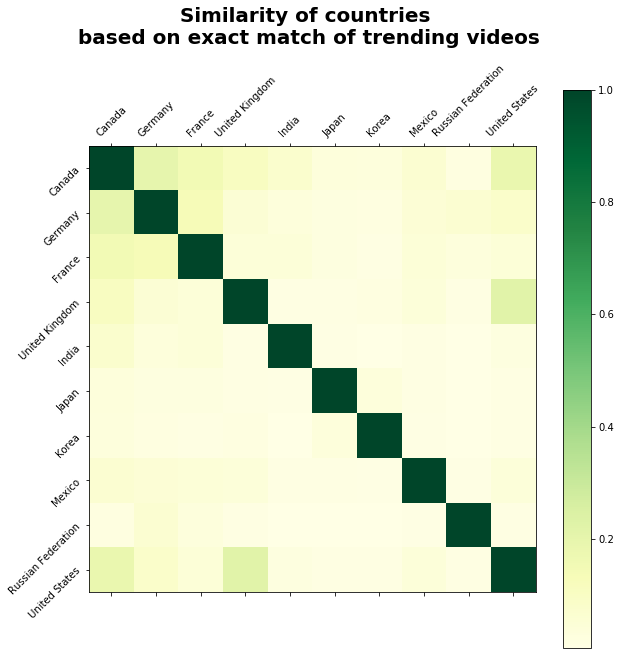

,Canada,Germany,France,United Kingdom,India,Japan,Korea,Mexico,Russian Federation,United States
Canada,1.000000,0.108787,0.082350,0.035823,0.036830,0.016097,0.015026,0.031149,0.010210,0.079434
Germany,0.108787,1.000000,0.071630,0.016352,0.017620,0.010194,0.008383,0.025347,0.031970,0.031615
France,0.082350,0.071630,1.000000,0.013119,0.019981,0.009829,0.007423,0.023293,0.014745,0.017676
United Kingdom,0.035823,0.016352,0.013119,1.000000,0.005292,0.005973,0.007535,0.011308,0.004819,0.118064
India,0.036830,0.017620,0.019981,0.005292,1.000000,0.005128,0.002869,0.008017,0.002697,0.010215
Japan,0.016097,0.010194,0.009829,0.005973,0.005128,1.000000,0.017515,0.006924,0.003553,0.007169
Korea,0.015026,0.008383,0.007423,0.007535,0.002869,0.017515,1.000000,0.005112,0.002961,0.006711
Mexico,0.031149,0.025347,0.023293,0.011308,0.008017,0.006924,0.005112,1.000000,0.006551,0.014826
Russian Federation,0.010210,0.031970,0.014745,0.004819,0.002697,0.003553,0.002961,0.006551,1.000000,0.004924
United States,0.079434,0.031615,0.017676,0.118064,0.010215,0.007169,0.006711,0.014826,0.004924,1.000000


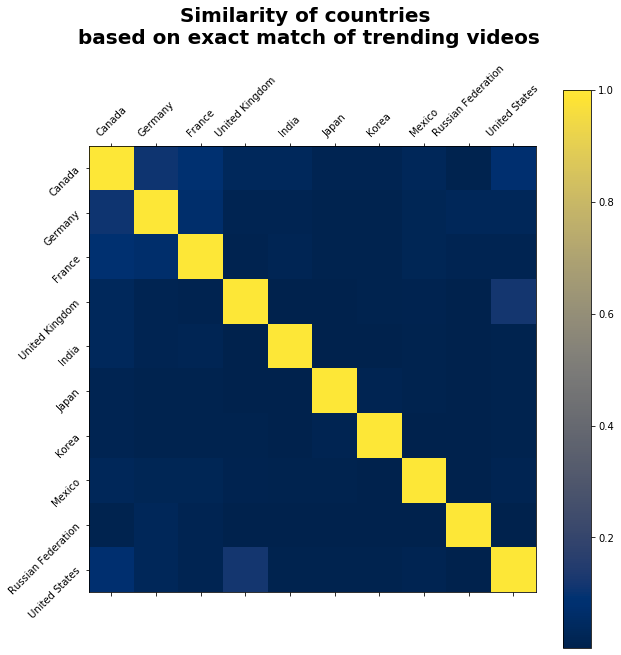

In [224]:
DF = DF1.groupby(['video_id', 'country'])['trending_date'].count().reset_index()
DF.columns = ['video_id','viewing_country','Total_Trend_Days']

Country_Video_Table = DF.groupby('viewing_country').aggregate(Video_List = ('video_id', lambda x: x.to_list()))

Country_Video_Table.index = [ISO_Alpha2_Country_Mapping[cc] for cc in Country_Video_Table.index]
Country_Video_Table

def Cosine_Similarity_Matrix(Table):
    N = Table.index.to_list()
    Sim_Matrix = pd.DataFrame(index=N, columns=N)
    for row in N:
        for col in N:
            Num = len(set(Table.loc[row][0]).intersection(set(Table.loc[col][0])))
            Denom = np.sqrt(len(Table.loc[row][0])*len(Table.loc[col][0]))
            Sim_Matrix.loc[row,col] = Num/Denom
    Sim_Matrix = Sim_Matrix.astype('float') 
    return Sim_Matrix

def Jaccard_Similarity_Matrix(Table):
    N = Table.index.to_list()
    Sim_Matrix = pd.DataFrame(index=N, columns=N)
    for row in N:
        for col in N:
            Num = len(set(Table.loc[row][0]).intersection(set(Table.loc[col][0])))
            Denom = len(set(Table.loc[row][0]).union(set(Table.loc[col][0])))
            Sim_Matrix.loc[row,col] = Num/Denom
    Sim_Matrix = Sim_Matrix.astype('float') 
    return Sim_Matrix

Similarity = Cosine_Similarity_Matrix(Country_Video_Table)
Similarity

_=plt.figure(figsize=(10,10))
_=plt.matshow(Similarity, fignum=1, cmap="YlGn")
_=plt.xticks(range(len(Similarity.columns)), Similarity.columns, rotation=45)
_=plt.yticks(range(len(Similarity.columns)), Similarity.columns, rotation=45)
_=plt.colorbar()
_=plt.suptitle('Similarity of countries\n based on exact match of trending videos', fontsize=20, weight='bold', x=0.45,y=0.98) 
_= plt.savefig('../Image/Correlation_on_video_watch_with_360217.png')
_=plt.show()

Similarity2 = Jaccard_Similarity_Matrix(Country_Video_Table)
Similarity2

_=plt.figure(figsize=(10,10))
_=plt.matshow(Similarity2, fignum=1, cmap="cividis")
_=plt.xticks(range(len(Similarity2.columns)), Similarity.columns, rotation=45)
_=plt.yticks(range(len(Similarity2.columns)), Similarity.columns, rotation=45)
_=plt.colorbar()
_=plt.suptitle('Similarity of countries\n based on exact match of trending videos', fontsize=20, weight='bold', x=0.45,y=0.98) 
#_= plt.savefig('../Image/Correlation_on_video_watch_with_360217.png')
_=plt.show()

In [227]:
Country_ISO_Dict = {val:key for key,val in ISO_Alpha2_Country_Mapping.items()}
Country_similarity = dict()
for i,j in zip(*np.where(Similarity>=0.1)):
    if (i!=j):
        Country_similarity[Country_ISO_Dict[Similarity.index[i]]]=Country_similarity.get(Country_ISO_Dict[Similarity.index[i]], [])+[Country_ISO_Dict[Similarity.index[j]]]
        
Country_similarity #Will be used later for censorship analysis 

Sorted_Similarity = Similarity.stack().sort_values(ascending=False)

Morethan10perc = Sorted_Similarity[Sorted_Similarity!=1][Sorted_Similarity[Sorted_Similarity!=1]>=0.1].reset_index()

Morethan10perc.reset_index(inplace=True)
Morethan10perc.columns = ['index', 'countries', 'relationship', 'similarity']

Morethan10perc['relationship'] = Morethan10perc.apply(lambda x: "Relationship: {}".format(x['index']//2 + 1), axis=1)

Morethan10perc['iso_code'] = Morethan10perc['countries'].map(Country_ISO_Dict)
Morethan10perc['iso_code_alpha3'] = Morethan10perc['iso_code'].map(lambda x: [item for item in countries.get(x)][2])
Country_RelationShip_Dict = Morethan10perc.groupby('countries').aggregate(relationships =  ('relationship', lambda x: '\n'.join(x.to_list()))).to_dict()['relationships']   
Morethan10perc['relationships'] = Morethan10perc['countries'].map(lambda x: "{}: {}".format(x, Country_RelationShip_Dict[x]))


import plotly.express as px

fig = px.line_geo(Morethan10perc, hover_name= 'relationships',locations="iso_code_alpha3",
                  color="relationship",
                  projection="equirectangular")

pio.write_html(fig, file='../Image/Conuntry_Similarity_based_on_what_is_trending_with_360217.html', auto_open=False)
#'equirectangular', 'orthographic'

fig.show()

{'CA': ['DE', 'FR', 'GB', 'US'],
 'DE': ['CA', 'FR'],
 'FR': ['CA', 'DE'],
 'GB': ['CA', 'US'],
 'US': ['CA', 'GB']}

## What categories are trended in which coutries? Is there a similarity?

* **We studied trending categories across countries and found "Entertainment" is the most trending category in all countries except Great Britain(GB) and Russia. In GB, Music outnumbered the Entertainment whereas in Russia "People & Blogs" surmounted Entertainment!** 

* **We clustered countries based on the how much they watch in each categories. The clustering method we chose is hierarchical clustering as we have only 10 countries to compare**
 - **Cluster1 - Canada, Germany, France, India, Japan and Mexico  - Significantly high interest in Entertainment compared to all other categories**
 - **Cluster2 - Korea & Russia - Along with Entertainment, they also have interest in News & Politics and People & Blogs**
 - **Cluster3 - UK & US - Common interest in Music & Entertainment**
 
* Note:- Data used is the original version as there was no NaN's for the Viewing Countries and Categories.

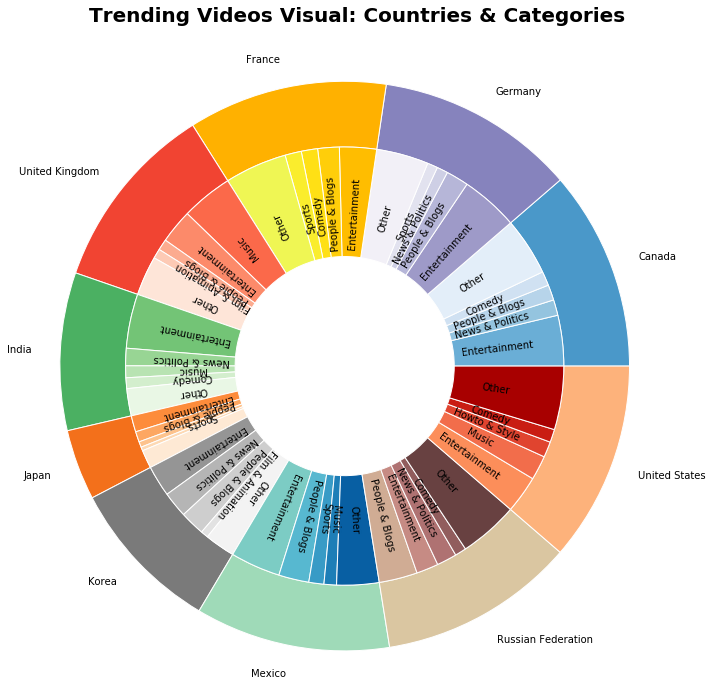

In [241]:
#Cleanup on the original DF
DF1 = pd.read_pickle("../Data/New_Video_DF_360217.pkl")
DF1.rename(columns={'country':'viewing_country'}, inplace=True)

List_of_JSON = [(file, file.split('_')[0]) for file in list(os.walk(os.path.join('..', 'Data')))[0][-1] if (file.endswith("category_id.json"))]   
Dict_Catogory = dict()
file = 'US_category_id.json'
with open(os.path.join('..', 'Data', file)) as f:
    data = json.load(f)
    Dict_Catogory.update({int(item['id']): item['snippet']['title'] for item in data['items']})
#Dict_Catogory

DF1['Category'] = DF1['category_id'].map(Dict_Catogory)
DF1.drop('category_id', axis=1, inplace=True)

DF = DF1.copy()

Country_Vs_Cat_Table = DF.groupby(['viewing_country', 'Category'])['video_id'].count().unstack()
Country_Vs_Cat_Table = Country_Vs_Cat_Table.fillna(value=0).astype('int64')

def toppers(x, how_many=3):
    toppers = {key:x.to_dict()[key] for key in sorted(x.to_dict(), key=lambda y: x.to_dict()[y], reverse=True)[:how_many]}
    toppers.update({'Other':x.sum() - sum(toppers.values())})
    return toppers

Outer = Country_Vs_Cat_Table.sum(axis=1)

Inner = Country_Vs_Cat_Table.apply(lambda x:toppers(x,4), axis=1) 

fig, axis = plt.subplots(figsize = (10,10))
_=axis.axis('equal')
color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges , plt.cm.Greys, plt.cm.GnBu_r, plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

#Outer pie
labels = [ISO_Alpha2_Country_Mapping[cc] for cc in Outer.index]
pie1= axis.pie(Outer, labels=labels, colors=colors,radius=1.3)  
_=plt.setp(pie1[0], width=0.3, edgecolor='white' )

#Inner pie
names = list(np.array([list(item) for item in Inner.map(lambda x: x.keys()).to_list()]).flatten())
values = list(np.array([list(item) for item in Inner.map(lambda x: x.values()).to_list()]).flatten())
colors = []
for color in color_range:
    colors = colors + [color(i) for i in [0.5,0.4,0.3,0.2,0.1]]
pie2 = axis.pie(values, radius=1.3-0.3, labels=names, labeldistance=0.7, colors=colors)
_=plt.setp(pie2[0], width=0.5, edgecolor='white')
_=plt.margins(0,0)

# do the rotation of the labels
for w, t in zip(pie2[0], pie2[1]):
    mang =(w.theta1 + w.theta2)/2.  # get mean_angle of the wedge
    #print(mang, t.get_rotation())
    _=t.set_rotation(mang)         # rotate the label by mean_angle
    _=t.set_va("center")
    _=t.set_ha("center")
    _=t.set
#Tiding up the clutter
#_=pie2[1][27].set_visible(False)
_=pie2[1][28].set_visible(False)
_=pie2[1][29].set_visible(False)


_=plt.suptitle('Trending Videos Visual: Countries & Categories', fontsize=20, weight='bold', y=1)

_=plt.tight_layout()
_= plt.savefig('../Image/Cat1_with_360217.png', bbox_inches = "tight" )
_=plt.show()

## Clustering of Countries based on the categories

array([0, 0, 0, 1, 0, 0, 2, 0, 2, 1])

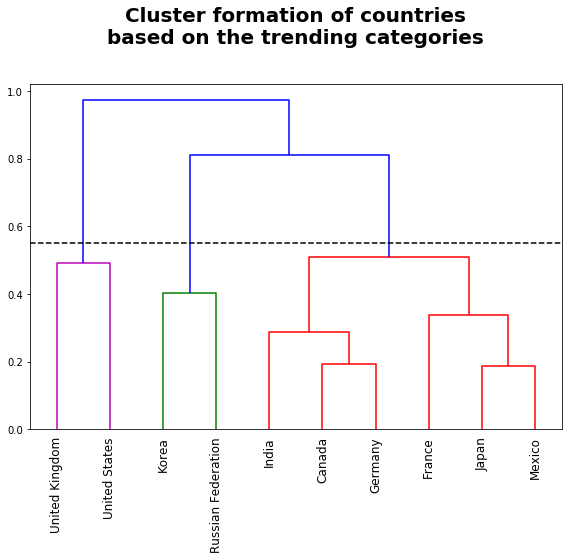

Category,Autos & Vehicles,Comedy,Education,Entertainment,Film & Animation,Gaming,Howto & Style,Movies,Music,News & Politics,Nonprofits & Activism,People & Blogs,Pets & Animals,Science & Technology,Shows,Sports,Trailers,Travel & Events
viewing_country,,,,,,,,,,,,,,,,,,
CA,0.021693,0.232403,0.061074,0.828108,0.126278,0.082829,0.123628,0.000370,0.229876,0.255945,0.004314,0.252740,0.022741,0.071058,0.007642,0.171698,0.000000,0.024159
DE,0.049505,0.143696,0.047861,0.866653,0.134282,0.088690,0.098954,0.000113,0.134509,0.166152,0.014517,0.339392,0.014233,0.045592,0.006068,0.156058,0.000057,0.007996
FR,0.046338,0.299406,0.052958,0.676525,0.148255,0.100469,0.162805,0.000759,0.271962,0.258446,0.007792,0.394013,0.016274,0.055234,0.006827,0.299406,0.000138,0.008206
GB,0.008323,0.105131,0.026413,0.520570,0.147554,0.102762,0.111431,0.000000,0.790536,0.070396,0.005202,0.168938,0.030805,0.029823,0.001156,0.109986,0.000000,0.005548
IN,0.004301,0.178835,0.071496,0.898786,0.088264,0.003241,0.049368,0.000623,0.195540,0.287918,0.006420,0.145050,0.000125,0.031603,0.009101,0.039208,0.000000,0.000499
JP,0.039165,0.084597,0.015144,0.754235,0.146913,0.121499,0.098522,0.000000,0.156661,0.174416,0.002263,0.482690,0.143606,0.018277,0.000000,0.258839,0.000000,0.015666
KR,0.008772,0.141502,0.034861,0.629781,0.151114,0.096115,0.039590,0.000000,0.128458,0.522377,0.020215,0.501247,0.051566,0.007781,0.011824,0.066899,0.000153,0.007018
MX,0.014574,0.100724,0.030852,0.780583,0.075044,0.057414,0.143212,0.000000,0.194690,0.180645,0.014691,0.472123,0.004878,0.030617,0.000176,0.235121,0.000000,0.006876
RU,0.109599,0.210719,0.049123,0.409665,0.209037,0.071828,0.138260,0.000070,0.130832,0.373155,0.106305,0.714847,0.041906,0.077714,0.013174,0.135667,0.000000,0.018220


In [246]:
from sklearn.preprocessing import normalize
#It normalize each sample (Row wise)
scaled_country = normalize(Country_Vs_Cat_Table)
scaled_country = pd.DataFrame(scaled_country, columns=Country_Vs_Cat_Table.columns, index=Country_Vs_Cat_Table.index)

import scipy.cluster.hierarchy as shc

_=plt.figure(figsize=(8, 8))  
_=plt.title("Cluster formation of countries\nbased on the trending categories", fontsize=20, weight='bold', y=1.1)

shc.set_link_color_palette(['m','g','r'])
dend = shc.dendrogram(shc.linkage(scaled_country, method='ward'), )
_=plt.axhline(y=0.55, color='k', linestyle='--')
_=plt.xticks(plt.xticks()[0], [ISO_Alpha2_Country_Mapping[scaled_country.index[id]] for id in dend['leaves']], rotation=90)

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(scaled_country)

_=plt.tight_layout()
#_= plt.savefig('../Image/Country_cluster_based_on_categories_with_360217.png', bbox_inches = "tight" )
_=plt.show()

scaled_country

In [248]:
Country_Cluster = pd.DataFrame(Country_Vs_Cat_Table.reset_index()['viewing_country'])
Country_Cluster['Country'] = Country_Cluster['viewing_country'].map(ISO_Alpha2_Country_Mapping)
Country_Cluster['iso_code_alpha3'] = Country_Cluster['viewing_country'].map(lambda x: [item for item in countries.get(x)][2])

Country_Cluster['Cluster'] = cluster.fit_predict(scaled_country)


import plotly.express as px

fig = px.choropleth(Country_Cluster, locations="iso_code_alpha3",
                    color="Cluster",
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale='sunset') #px.colors.sequential.Plasma
fig.show()
pio.write_html(fig, file='../Image/Country_Clusters_based_on_what_categories_are_trending_with_360217.html', auto_open=False)

## Is there any difference in popularity (longevity) across categories ?

**We define popularity(longevity) as the number the days of trending**
- **Almost all categories have a varying popularity**
- **However, it looks like "Music videos" tend to have relatively longer limelight (Avg >3, whereas all other categories have mean trending days <3)**
- **Note that "Trailers" and "Movies" are significantly less in numbers in the dataset(2, 13 respectively). Hence, it is not enough evidence to say that, they trend less. They are excluded in the visualization**

Note:- Data used is the cleaned(shorter) version as we would be using the shorter version for model building as it is devoid of NaNs for a wide variety of features. Hence, we need to analyse the factors affecting popularity with the same Data

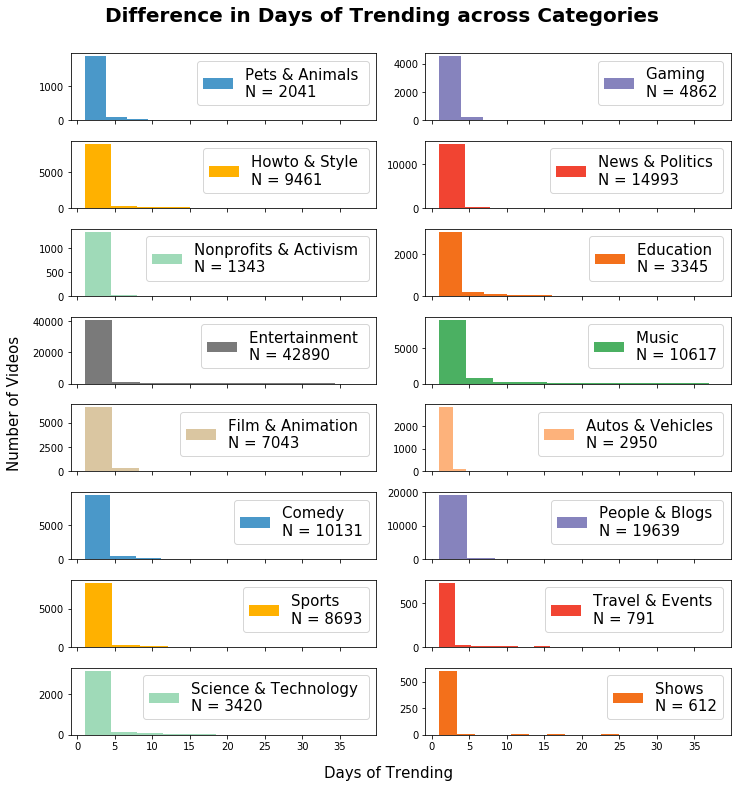

In [250]:
DF = pd.read_pickle('../Data/Popularity_DF.pkl')


List_of_Cats = DF['Category'].unique()
Category_Count = pd.DataFrame(DF['Category'].value_counts())

fig, axs = plt.subplots(8, 2, sharex=True, sharey=False, tight_layout=True, figsize=(10,10))
axs = axs.ravel()
color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,cat in enumerate(List_of_Cats[:-2]):
    _=axs[index].hist(DF[DF['Category']==cat]['Total_Trend_Days'], color=colors[index%10], alpha=1, label=f"{cat} \nN = {Category_Count.loc[cat, 'Category']}")

    #legend
    _=axs[index].legend(loc='upper right', fontsize = 15)
    

    
_=plt.suptitle('Difference in Days of Trending across Categories', fontsize=20, weight='bold', y=1.05) 
#xlabel, ylabel
_=fig.text(-0.02, 0.5, 'Number of Videos', va='center', rotation='vertical', fontsize = 15)
_=fig.text(0.51, -0.02, 'Days of Trending', ha='center', rotation='horizontal', fontsize = 15)


_ = plt.tight_layout()
_= plt.savefig('../Image/Popularity_Across_Categories.png', bbox_inches = "tight" )
plt.show()

In [253]:
DF.groupby('Category')['Total_Trend_Days'].describe()

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
Autos & Vehicles,2950.0,1.330508,1.030026,1.0,1.00,1.0,1.00,19.0
Comedy,10131.0,2.084000,2.181306,1.0,1.00,1.0,2.00,35.0
Education,3345.0,1.868161,2.241602,1.0,1.00,1.0,2.00,31.0
Entertainment,42890.0,1.788296,2.132509,1.0,1.00,1.0,2.00,38.0
Film & Animation,7043.0,2.037058,2.820366,1.0,1.00,1.0,2.00,37.0
Gaming,4862.0,1.885438,2.381924,1.0,1.00,1.0,2.00,30.0
Howto & Style,9461.0,1.758799,2.364859,1.0,1.00,1.0,2.00,36.0
Movies,13.0,2.076923,2.253203,1.0,1.00,1.0,2.00,8.0
Music,10617.0,3.303664,5.080521,1.0,1.00,2.0,3.00,37.0


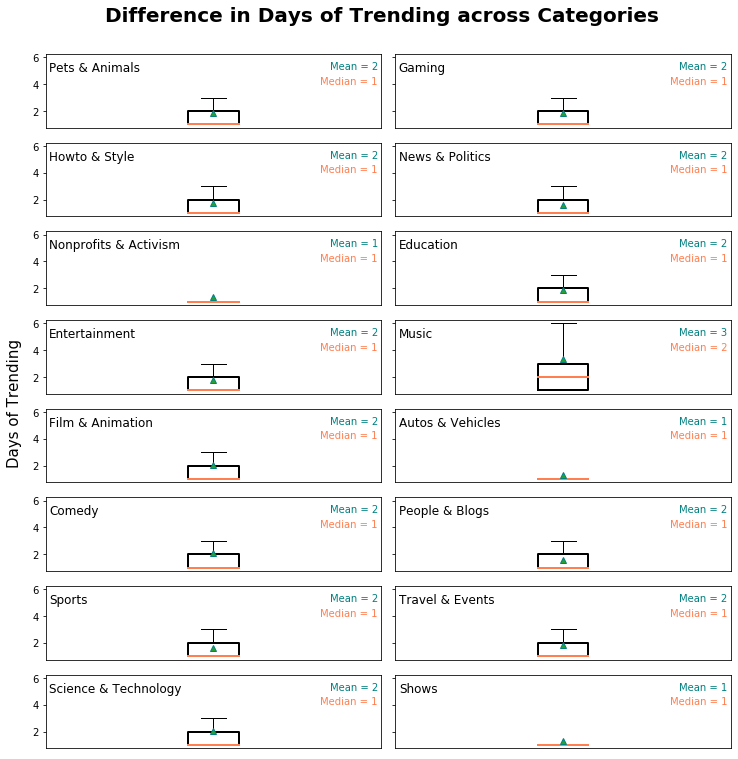

In [349]:
#Box plot to convey the same effectively!
boxprops = dict(linestyle='-', linewidth=2, color='k')
medianprops = dict(linestyle='-', linewidth=2, color='coral')
meanprops = dict(markeredgecolor='teal')
fig, axs = plt.subplots(8, 2, sharex=True, sharey=True, tight_layout=True, figsize=(10,10))
axs = axs.ravel()

color_range = [plt.cm.Blues, plt.cm.Purples, plt.cm.Wistia, plt.cm.Reds, plt.cm.GnBu_r, plt.cm.Oranges , plt.cm.Greys, plt.cm.Greens , plt.cm.pink, plt.cm.OrRd_r]
colors = [color(0.6) for color in color_range]

for index,cat in enumerate(List_of_Cats[:-2]):
    Dict = axs[index].boxplot(DF[DF['Category']==cat]['Total_Trend_Days'], 
                                      showfliers=False,
                                      showmeans=True,
                                      boxprops=boxprops,
                                      medianprops=medianprops,
                                      meanprops=meanprops)
    #_=axs[index].legend([cat], loc='upper right', fontsize = 10)
    _=axs[index].text(0.01,0.9, cat,
                     fontsize=12,
                     horizontalalignment='left',
                     verticalalignment='top',
                     transform = axs[index].transAxes)
   
    _=axs[index].set_xticklabels([])
    _=axs[index].set_xticks([])
    
    #Annotate
        
    for line in Dict['medians']:
        # get position data for median line
        x, y = line.get_xydata()[1] # top of median line
        # overlay median value
        _=axs[index].text(0.99,0.7, "Median = {:.0f}".format(y),
             horizontalalignment='right',
                          verticalalignment='top',
                          color='coral',
                         transform = axs[index].transAxes)

    for line in Dict['means']:
        # get position data for median line

        x, y = line.get_xydata()[0] # top of median line
        # overlay mean value
        _=axs[index].text(0.99, 0.9, "Mean = {:.0f}".format(y),
             horizontalalignment='right',
                        verticalalignment='top',
                        color='teal',
                       transform = axs[index].transAxes)

_=plt.suptitle('Difference in Days of Trending across Categories', fontsize=20, weight='bold', y=1.05) 

#xlabel, ylabel
_=fig.text(-0.02, 0.5, 'Days of Trending', va='center', rotation='vertical', fontsize = 15)


_ = plt.tight_layout()
_= plt.savefig('../Image/Popularity_Across_Categories_box_plot.png', bbox_inches = "tight" )

plt.show()


# Feature Selection

**We used statistical measures to understand the prominent features (attributes) that affects popularity (No. of days of trending)**
- **Since the number of days of trending(popularity), we cannot treat this problem as a regression problem and use statistical methods. Hence, we have categorized the popularity into 4 ranges**
 - 1Day Trending -> 'JustTrending'
 - 1 to 5 Days Trending-> 'Popular'
 - 5 to 14 Days Trending -> 'UlraPopular'
 - \>14 Days Trending -> 'Phenomenon'
- **Used Chi-squared Feature Selection for categorical features**
- **Use ANOVA test for numeric features**
**Please note that this study is a preliminary one and doesn't identify the combined effects of attributes on output**


## Feature Selection of Categorical Variables

Feature 0: 9136.199843
Feature 1: 1763.807408
Feature 2: 26352.847353
Feature 3: 49299.231133
Feature 4: 126.115758
Feature 5: 91.221857
Feature 6: 133.616390
Feature 7: 72.862969
Feature 8: 121.805762


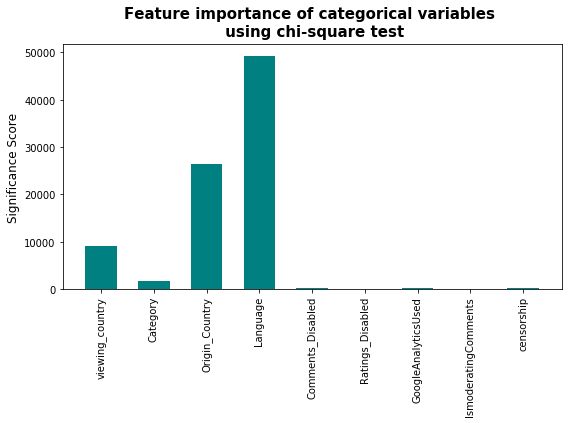

array([ 9136.19984317,  1763.80740809, 26352.84735332, 49299.23113338,
         126.11575757,    91.22185733,   133.61638978,    72.86296909,
         121.80576155])

In [350]:
## Chi-Squared / ANOVA Feature Selection function

from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

# prepare input data
def encode(X):
    oe = OrdinalEncoder()
    oe.fit(X) 
    return oe


def feature_selection(DF, function, ravel=False):
    
    columns = DF.columns
    #Create separate encoders for input and output
    encoder_X = encode(DF[columns[:-1]])
    X = encoder_X.transform(DF[columns[:-1]])

    encoder_Y = encode(DF['Popularity_Category'].to_numpy().reshape(-1,1))
    Y = encoder_Y.transform(DF['Popularity_Category'].to_numpy().reshape(-1,1))
    if ravel:
        Y=Y.ravel()
    fs = SelectKBest(score_func=function, k='all')
    fs.fit(X, Y)
    
    # what are scores for the features
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i, fs.scores_[i]))
    # plot the scores
    fig, ax = plt.subplots(figsize=(8,6))
    _=plt.bar([i for i in range(len(fs.scores_))], fs.scores_, color='teal', width=0.6)
    _=plt.xticks([i for i in range(len(fs.scores_))], columns[:-1], rotation=90)
    _=plt.ylabel('Significance Score', fontsize=12)

    a,b=(('categorical', 'chi-square') if function==chi2 else ('numeric', 'ANOVA'))
    label = "Feature importance of {} variables \n using {} test".format(a,b)
    _=plt.title(label, fontsize=15, weight='bold', y=1.01)
    _=plt.tight_layout()
    _= plt.savefig('../Image/Feature_Selection_of_{}variables.png'.format(a), bbox_inches = "tight" )
    plt.show()
    
    return fs.scores_

def Basic_Cleanup():
    DF = pd.read_pickle('../Data/Popularity_DF.pkl')

    #Language fill NaN and cleanup
    DF['Language'].fillna('Unknown', inplace=True)
    DF['Language'].replace({'English (United Kingdom)':'English', 'Spanish (Latin America)':'Spanish', 'Spanish (Spain)':'Spanish'}, inplace=True)

    Country_Category_Popularity_DF = DF[['viewing_country', 'Category', 'Origin_Country', 'Language', 'Comments_Disabled', 'Ratings_Disabled', 'Blocked', 'Allowed', 'GoogleAnalyticsUsed', 'IsmoderatingComments', 'Total_Trend_Days']].copy()

    #import missingno as msno
    #_=msno.matrix(Country_Category_Popularity_DF)
    #Origin_Country fill NaN and cleanup
    Country_Category_Popularity_DF['Origin_Country'].fillna(value='Not_Disclosed', inplace=True)
    return Country_Category_Popularity_DF


def map_to_cat(x):
    #np.quantile(Country_Category_Popularity_DF['Total_Trend_Days'], [0.95, 0.999])
    #1 -> 'JustTrending'
    #(1 to 5] -> 'Popular' #5 is 95th %
    #(5 to 14] -> 'UlraPopular' #14 is 99.1%
    #>14 -> 'Phenomenon'
    return ('JustTrending' if x==1 else ('Popular' if x<=5 else ('UltraPopular' if x<=14 else "Phenomenon")))

#Retrieve Country_Category_Popularity_DF after basic cleanup
Country_Category_Popularity_DF = Basic_Cleanup()
#Derive a new variable censorship if any blocking
Country_Category_Popularity_DF['censorship'] = Country_Category_Popularity_DF.apply(lambda x: (False if ((x['Blocked']!=x['Blocked']) and (x['Allowed']!=x['Allowed'])) else True),axis=1)
Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      
Country_Category_Popularity_DF.drop(['Blocked', 'Allowed', 'Total_Trend_Days'], inplace=True, axis=1)

feature_selection(Country_Category_Popularity_DF, chi2)
#_=msno.matrix(Country_Category_Popularity_DF)


## Feature Selection of Numeric Variables  (ANOVA Test)

Feature 0: 200.768561
Feature 1: 406.064902
Feature 2: 5835.287534
Feature 3: 5480.808362
Feature 4: 2524.251736
Feature 5: 3911.372618
Feature 6: 1015.285355


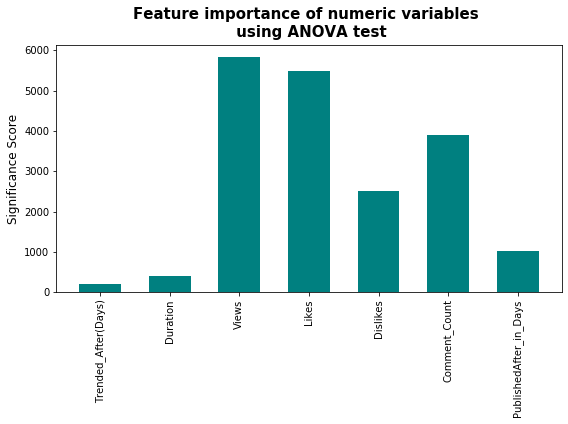

array([ 200.76856128,  406.06490198, 5835.28753387, 5480.80836217,
       2524.25173613, 3911.37261773, 1015.28535524])

In [351]:
def indays(x,y):
    z=x.date()-y.date()
    return z.days
def Basic_Cleanup_Numeric():
    DF = pd.read_pickle('../Data/Popularity_DF.pkl')

    DF['Trended_After(Days)'] = DF.apply(lambda x: indays(x['First_Trending'],x['Publish_Time']), axis=1)

    Country_Category_Popularity_DF = DF[['viewing_country', 'Trended_After(Days)','Duration', 'Views', 'Likes', 'Dislikes', 'Comment_Count', 'PublishedAfter_in_Days', 'Blocked', 'Allowed', 'Total_Trend_Days']].copy()
    
    
    Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      
    Country_Category_Popularity_DF.drop(['viewing_country', 'Blocked', 'Allowed', 'Total_Trend_Days'], inplace=True, axis=1)

    return Country_Category_Popularity_DF


#Retrieve Country_Category_Popularity_DF after basic cleanup
Country_Category_Popularity_DF = Basic_Cleanup_Numeric()

feature_selection(Country_Category_Popularity_DF, f_classif, ravel=True)
#_=msno.matrix(Country_Category_Popularity_DF)

# Study on Boolean Categorical Variables

* **Based on the feature selection study, it appears that Boolean Categorical variables are less significant than others**

* **In this section, we study if they are any significant at all**

In [354]:
Country_Category_Popularity_DF = DF[['viewing_country', 'Category', 'Origin_Country', 'Language', 'Comments_Disabled', 'Ratings_Disabled', 'Blocked', 'Allowed', 'GoogleAnalyticsUsed', 'IsmoderatingComments', 'Total_Trend_Days']].copy()
Country_Category_Popularity_DF['Popularity_Category'] = Country_Category_Popularity_DF['Total_Trend_Days'].map(lambda x: map_to_cat(x))      

def plot_popularity_distribution(col, text, filename, legend=None, title=None):
    #col:- Column name in Country_Category_Popularity_DF you want to analyse the significance for
    #text:- text in the graph
    #filename:- filename to save
    #legend:- legend names as a list
    
    contingency_table=Country_Category_Popularity_DF.groupby(col)['Popularity_Category'].value_counts().unstack()
    
    stat, p, dof, expected = chi2_contingency(contingency_table)


    # interpret p-value
    alpha = 0.01
    if p <= alpha:
        print(f'Popularity depends on {col} (reject H0)')
    else:
        print(f'Popularity is independent of {col} (fail to reject H0)')
    
    DF=pd.DataFrame(Country_Category_Popularity_DF.groupby(col)['Popularity_Category'].value_counts(normalize=True))
    DF.columns = ['Percentage']
    DF = DF.unstack(level=0)
    DF = DF.loc[['JustTrending', 'Popular', 'UltraPopular', 'Phenomenon'],:]
    DF['Percentage']=DF['Percentage']*100

    DF.columns.name = col
    if legend==None:
        DF.columns = [col[1] for col in DF.columns]
    else:
        DF.columns = legend
        
    yTicks = np.arange(0, (DF.max().max()//10)*10 + 11, 10)
    ax = DF.plot.bar(rot=0, figsize=(6,4), color=['teal', 'blue'], width=0.6)

    #Beautification !!!
    suptitle = (f'Popularity Distribution\n with and without {col.capitalize()}' if title==None else title)
    _=plt.suptitle(suptitle, fontsize=16, weight='bold', y=1.08)
    _=plt.yticks(yTicks, [f"{val}%" for val in yTicks])

    #xlabel, ylabel
    _=plt.xlabel('Popularity Category',fontsize = 14)
    _=plt.ylabel('Percentage',fontsize = 14)

    #legend
    _=plt.legend(loc='upper right', fontsize = 12)
    text = "{}\np-value = {:.1f}".format(text, p)
    bbox_props = dict(boxstyle="round", fc="lightcoral", ec="grey", lw=2, alpha=0.3)
    t = ax.text(0.6, 0.6, text, ha="center", va="center",
            size=10, transform=ax.transAxes,
            bbox=bbox_props)

    _ =plt.tight_layout()
    ax.get_figure().savefig(f'../Image/{filename}',bbox_inches = "tight" )
    

Popularity depends on censorship (reject H0)
Popularity depends on IsmoderatingComments (reject H0)
Popularity depends on GoogleAnalyticsUsed (reject H0)
Popularity depends on Ratings_Disabled (reject H0)
Popularity depends on Comments_Disabled (reject H0)


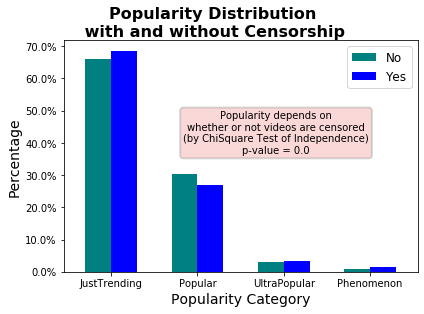

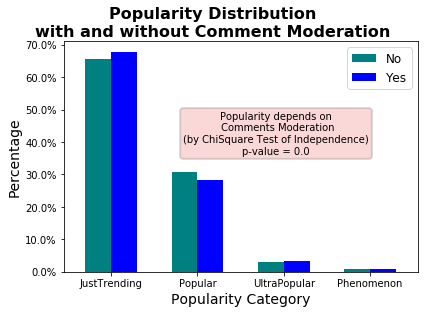

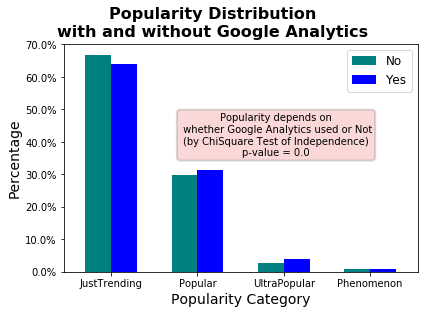

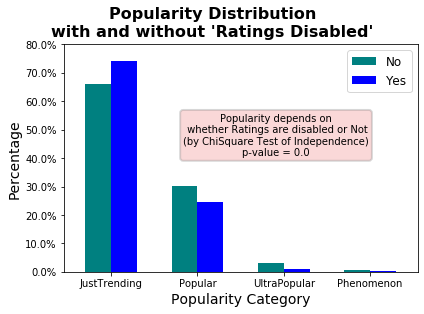

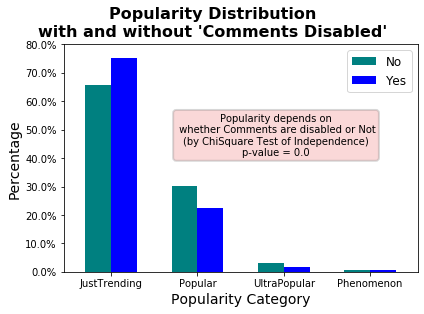

In [355]:
###Censorship

Country_Category_Popularity_DF['censorship'] = Country_Category_Popularity_DF.apply(lambda x: (False if ((x['Blocked']!=x['Blocked']) and (x['Allowed']!=x['Allowed'])) else True),axis=1)
plot_popularity_distribution('censorship', "Popularity depends on\nwhether or not videos are censored\n(by ChiSquare Test of Independence)", 'Effect_of_Censorship_on_popularity.png', legend=["No", "Yes"])


### Study on Comment Moderation
plot_popularity_distribution('IsmoderatingComments', "Popularity depends on\n Comments Moderation\n(by ChiSquare Test of Independence)", 'Effect_of_Comment_Moderation_on_popularity.png', legend=["No", "Yes"], title="Popularity Distribution\nwith and without Comment Moderation" )


## Study on Google Analytics
plot_popularity_distribution('GoogleAnalyticsUsed', "Popularity depends on\n whether Google Analytics used or Not\n(by ChiSquare Test of Independence)", 'Effect_of_Google_Analytics_on_popularity.png', legend=["No", "Yes"], title="Popularity Distribution\nwith and without Google Analytics" )

## Study on Ratings Disabled
plot_popularity_distribution('Ratings_Disabled', "Popularity depends on\n whether Ratings are disabled or Not\n(by ChiSquare Test of Independence)" , 'Effect_of_Ratings_Disabled_on_popularity.png',legend=["No", "Yes"], title="Popularity Distribution\nwith and without 'Ratings Disabled'")    


## Study on Comments Disabled
plot_popularity_distribution('Comments_Disabled', "Popularity depends on\n whether Comments are disabled or Not\n(by ChiSquare Test of Independence)", 'Effect_of_Ratings_disabled_or_Not_on_popularity.png', legend=["No", "Yes"], title="Popularity Distribution\nwith and without 'Comments Disabled'" )



## Analyzing the top ten videos with the longest maximum trending time

### Approach:
* Created a list of all the 10 countries videos trend in.
* Created a list of the top ten video_ids that have the highest total number of trending days
* Used the list of video_ids and countries to generate a 2D array to store the number of days a video trends in each country.
* Generated a heatmap to represent the total number of trending days for each video in each of the countries 

### Insights:
* Each of the top longest trending videos have trended the longest in the UK
* The same videos that achieves such a high popularity in the UK by trending for 38 days only trends for 0 to 6 days in most other countries and in the US trends for about 10 to 20 days 
* There is a very large difference in the number of days videos trend in UK compared to other countries
* This raises the question do all occurrences of total trending days that are higher than 20 occur in UK ? If this is the case why does this happen?

In [362]:
#import data into a dataframe
df=pd.read_pickle("../Data/Popularity_DF.pkl")
#sorting dataframe by total trending days in decsending order
dfmax= df.sort_values(by="Total_Trend_Days", ascending=False)
#droping repeating entries for the trend time in each country so that we have the highest trend time for each unique video_id 
dfmax.drop_duplicates("video_id", inplace=True)
#Creating a list of top ten longest trendinding videos
#Taking the top ten unique video_ids
dfmax10=dfmax.head(10)
topTitlesList= dfmax10["Video_Title"]
topTitlesList=topTitlesList.tolist()
topVideoIdList=dfmax10["video_id"]
topVideoIdList=topVideoIdList.tolist()
topTitlesList= [re.sub(' +', ' ',name)[0:40] for name in topTitlesList]
kylie=df[df["Video_Title"]=="To Our Daughter"]
topTitlesList[1]=topTitlesList[1]+" | "+kylie.iloc[0,8].split('|')[0]
topTitlesList

#There are 10 countries for which the trending data was collected to create this dataset. Creating a list of all the countries vidoes trend in, in this dataset
countryCodeList= df["viewing_country"].value_counts().index
countryCodeList=countryCodeList.tolist()

countryList = [ISO_Alpha2_Country_Mapping[cc] for cc in countryCodeList]
countryList

#Creating a 2D array that has video_id as the row No. and the each of the 10 countries 
#as the columns. The values stored in the 2D array are total trending days that correspond 
#to the video_id and the country that the video trended in. 
list1=[]
list2=[]
temp=[]
count=0
for videoid in topVideoIdList:
    dftemp= df[df["video_id"]==videoid]
    for country in countryCodeList:
        try:
            dftemp2=dftemp[dftemp["viewing_country"]==country]
            list2.append(int(dftemp2["Total_Trend_Days"]))
        except:
            list2.append(0)
    list1.append(list2)
    list2=[]
    
list1= np.array(list1)
list1

['Jurassic World: Fallen Kingdom - Officia',
 'Justin Timberlake’s FULL Pepsi Super Bow | People & Blogs',
 'To Our Daughter',
 'Fergie Performs The U.S. National Anthem',
 'Incredibles 2 - Olympics Sneak Peek',
 'Rich Brian - Cold (Official Music Video)',
 'Miguel - Come Through and Chill ft. J. C',
 'VENOM - Official Teaser Trailer (HD)',
 'Whethan, Dua Lipa - High (Audio)',
 '[OFFICIAL VIDEO] HAVANA - PENTATONIX']

['Russian Federation',
 'Germany',
 'France',
 'Mexico',
 'Canada',
 'India',
 'Korea',
 'Japan',
 'United States',
 'United Kingdom']

array([[ 2,  5,  3,  3,  6,  6,  2,  0, 10, 38],
       [ 2,  5,  5,  3,  6,  0,  0,  0,  4, 38],
       [ 2,  5,  4,  3,  6,  0,  1,  0, 10, 38],
       [ 0,  3,  2,  1,  7,  0,  0,  0,  7, 37],
       [ 0,  5,  4,  2,  7,  6,  5,  1, 11, 37],
       [ 0,  1,  1,  0,  4,  0,  0,  0,  0, 37],
       [ 0,  0,  1,  0,  4,  0,  0,  0, 17, 37],
       [ 0,  3,  3,  2,  5,  5,  2,  1, 10, 37],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 37],
       [ 1,  3,  2,  1,  5,  0,  2,  1, 13, 37]])

### Heatmap to show the number of Total trending days for each Video in each Country

Text(0.5, 1.292771587738431, 'Popularity of videos based on viewing country')

Text(0.5, 26.6, 'Viewing Country')

Text(-199.34999999999994, 0.5, 'Video Name')

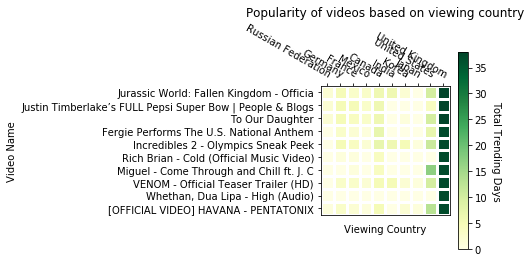

In [363]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(True)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    

    return im, cbar


fig, ax = plt.subplots()

im, cbar = heatmap(list1, topTitlesList, countryList, ax=ax,
                   cmap="YlGn", cbarlabel="Total Trending Days")
#texts = annotate_heatmap(im)

fig.tight_layout()
plt.title("Popularity of videos based on viewing country")
plt.xlabel("Viewing Country")
plt.ylabel("Video Name")
plt.savefig("../Image/PopularityVsVideoid")
plt.show()

## Further investigating the number of total trending days by Country
### Approach:
* Created a dataframe with all the rows that have viewing country set to GB 
* Created a dataframe with all the rows that don't have viewing country set to GB 
* Created a Scatter plot that has the row number as the x-axis and the total trending days as the y-axis. UK is represented by an orange color and all other countries are represented with the blue color
* Created a histogram plot that has the total trending days as the x-axis and frequency of occurrence as the y-axis. UK is represented by an orange color and all other countries are represented with the blue color

### Insights:
* All videos that trend longer than 29 days have trended in UK
* This is not a normal distribution so we cannot do a T-test to check whether there is a significant difference between the mean value of total trending days in UK verses the total trending days in other countries

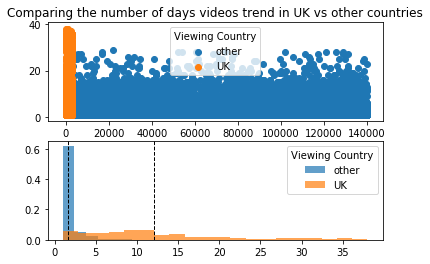

In [365]:
def gendata(sample,population):
    #population = stats.norm.rvs(size=1000, random_state=42)
    #sample = stats.norm.rvs(loc=loc, size=200, random_state=42)

    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    #plt.figure(figsize=(6,6))
    plt.title("Comparing the number of days videos trend in UK vs other countries")
    plt.scatter(range(len(population)), population, label="other")
    plt.scatter(range(len(sample)), sample, label="UK")
    plt.legend(title="Viewing Country")

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    #plt.figure(figsize=(6,6))
    plt.hist(population, 20, density=True, alpha=0.7, label="other")
    plt.hist(sample, 20, density=True, alpha=0.7, label="UK")
    plt.axvline(population.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(sample.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend(title="Viewing Country")  
    plt.savefig("../Image/UKvsOther")
    
    return population, sample

sample= df[df["viewing_country"]=="GB"]["Total_Trend_Days"]
population=df[df["viewing_country"]!="GB"]["Total_Trend_Days"]
population, sample= gendata(sample,population)

## Best trending across Countries
### Approach:
* Created a series that has the max value of total trending days for each country 
* Sorted the vales in the series in desending order and created a bar graph

### Insights:
* Videos trend in UK from 1 to 38 days
* Videos trend in US from 1 to 29 days
* Videos trend in India from 1 to 10 days
* Videos trend in Canada from 1 to 8 days
* Videos trend in all other countries for less than 8 days

viewing_country
GB    38
US    29
IN     9
CA     8
KR     7
DE     7
FR     5
RU     4
MX     4
JP     3
Name: Total_Trend_Days, dtype: int64

<BarContainer object of 10 artists>

Text(0.5, 0, 'Viewing Country')

Text(0, 0.5, 'Maximum Total Number of Days videos have trended')

Text(0.5, 1, 'The longest videos trend in each country')

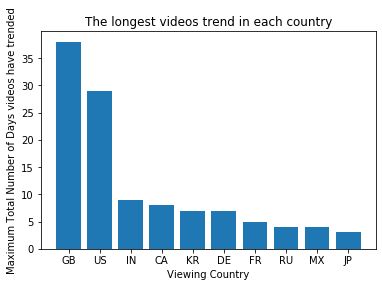

In [367]:
dfmaxCountry= df.groupby("viewing_country")["Total_Trend_Days"].max()
dfmaxCountry.sort_values(ascending=False, inplace=True)
dfmaxCountry

plt.bar(dfmaxCountry.index, dfmaxCountry)
plt.xlabel("Viewing Country")
plt.ylabel("Maximum Total Number of Days videos have trended")
plt.savefig("../Image/maxTrendingPerCountry")
plt.title("The longest videos trend in each country")